# Caltech EV Charging data Energy Demand Predictions

In [510]:
import numpy
import pandas as pd
import json
import datetime
file_path = './acndata_sessions.json'

with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [511]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [512]:
file_path = './acndata_sessions.json'

with open(file_path, "r") as read_file:
    data = json.load(read_file)

In [513]:
def singleNumeric(data):
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(0, inplace=True)
    return data

In [514]:
scaler=StandardScaler()

def scaleData(data):
    scaler.fit(data)
    return scaler.transform(data)

In [515]:
df = pd.DataFrame(data['_items'])

Convert time related columns to datetime

Extract year, month, calendar week, day and day of week from the connectionTime as these individual pieces of time info are valuable.

In [516]:
df["connectionTime"] = pd.to_datetime(df["connectionTime"])
df["disconnectTime"] = pd.to_datetime(df["disconnectTime"])
df["doneChargingTime"] = pd.to_datetime(df["doneChargingTime"])
df['connectionTime_year'] = df['connectionTime'].dt.year
df['connectionTime_month'] = df['connectionTime'].dt.month
df['connectionTime_week'] = df['connectionTime'].dt.isocalendar().week
df['connectionTime_day'] = df['connectionTime'].dt.day
df['connectionTime_dayofweek'] = df['connectionTime'].dt.dayofweek

Drop columns that aren't useful

In [517]:
df = df.drop("timezone", axis=1)
df = df.drop("stationID", axis=1)
df = df.drop("userID", axis=1)
df = df.drop("sessionID", axis=1)
df = df.drop("clusterID", axis=1)
df = df.drop("userInputs", axis=1)

In [518]:
def models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled):
    
    # Define sequential model, two input layers, 11 input dimensions as there are 11 columns
    model = Sequential()
    model.add(Dense(128, input_dim=11, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #Output layer
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    model.summary()

    history = model.fit(x_trainScaled, y_train, validation_split=0.2, epochs =100)

    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Predict on test data
    predictions = model.predict(x_testScaled[:5])
    print("\nPredicted values are: \n", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    #Neural network - from the current code
    mse_neural, mae_neural = model.evaluate(x_testScaled, y_test)
    print('\nMean squared error from neural net: \n', mse_neural)
    print('\nMean absolute error from neural net: \n', mae_neural)

    x_testScaled_reshape = x_testScaled.reshape(x_testScaled.shape[0], x_testScaled.shape[1], 1)
    x_test_timesteps, x_test_features= x_testScaled_reshape.shape[1], x_testScaled_reshape.shape[2]

    n_outputs = y_train.shape[0]
    
    # Convolutional Neural Net
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_test_timesteps,x_test_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    #Predict on test data
    predictions = model.predict(x_testScaled_reshape[:5])
    print("\nPredicted values are:\n ", predictions)
    print("\nReal values are: \n", y_test[:5])

    #Comparison with other models..
    mse_neural, mae_neural = model.evaluate(x_testScaled_reshape, y_test)
    print('\nMean squared error from Convolutional neural net: ', mse_neural)
    print('\nMean absolute error from Convolutional neural net: ', mae_neural)

    ### Linear regression
    lr_model = linear_model.LinearRegression()
    lr_model.fit(x_trainScaled, y_train)
    y_pred_lr = lr_model.predict(x_testScaled)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    print('\nMean squared error from linear regression: ', mse_lr)
    print('\nMean absolute error from linear regression: ', mae_lr)

    tree = DecisionTreeRegressor()
    tree.fit(x_trainScaled, y_train)
    y_pred_tree = tree.predict(x_testScaled)
    mse_dt = mean_squared_error(y_test, y_pred_tree)
    mae_dt = mean_absolute_error(y_test, y_pred_tree)
    print('\nMean squared error using decision tree: ', mse_dt)
    print('\nMean absolute error using decision tree: ', mae_dt)

    #Random forest.
    model = RandomForestRegressor(n_estimators = 100, random_state=0)
    model.fit(x_trainScaled, y_train)

    y_pred_RF = model.predict(x_testScaled)

    mse_RF = mean_squared_error(y_test, y_pred_RF)
    mae_RF = mean_absolute_error(y_test, y_pred_RF)
    print('\nMean squared error using Random Forest: ', mse_RF)
    print('\nMean absolute error Using Random Forest: ', mae_RF)

    #Feature ranking...
    feature_list = list(x_train.columns)
    feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
    print("\n The features ranking by importance to the RF Model")
    print("\n", feature_imp)

# Predict 1 Day with 2 Weeks of Data

In [519]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [520]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [521]:
test = test.loc[test['connectionTime_day'] == 22]

In [522]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [523]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_311 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_312 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_313 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 27ms/step - loss: 442.7556 - mean_absolute_error: 14.8650 - val_loss: 283.7741 - val_mean_absolute_error: 11.8328
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 424.0959 - mean_absolute_error: 14.2693 - val_loss: 268.9877 - val_mean_absolute_error: 11.2733
Epoch 3/100
5/5 [============================

Epoch 46/100
5/5 [==============================] - 0s 6ms/step - loss: 151.6187 - mean_absolute_error: 8.9426 - val_loss: 116.9889 - val_mean_absolute_error: 8.5823
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 151.3719 - mean_absolute_error: 8.9568 - val_loss: 118.3730 - val_mean_absolute_error: 8.6475
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 151.3963 - mean_absolute_error: 8.9367 - val_loss: 118.4404 - val_mean_absolute_error: 8.6473
Epoch 49/100
5/5 [==============================] - 0s 6ms/step - loss: 151.1734 - mean_absolute_error: 8.9195 - val_loss: 120.0001 - val_mean_absolute_error: 8.7344
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 151.2402 - mean_absolute_error: 8.9375 - val_loss: 122.9815 - val_mean_absolute_error: 8.9004
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.1404 - mean_absolute_error: 8.9648 - val_loss: 125.3374 - val_mean_absolute_error: 9.0374
Epoc

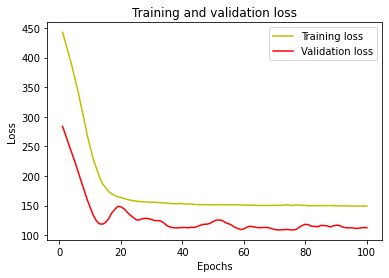


Predicted values are: 
 [[24.172838 ]
 [24.047056 ]
 [ 5.7382236]
 [ 7.9264383]
 [23.740171 ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 15ms/step - loss: 73.1147 - mean_absolute_error: 6.9795

Mean squared error from neural net: 
 73.11471557617188

Mean absolute error from neural net: 
 6.979510307312012

Predicted values are:
  [[0.00515771 0.0056405  0.00583359 0.00580231 0.00538082 0.0063639
  0.00548466 0.00596547 0.00530881 0.00587584 0.0056279  0.00552278
  0.00599245 0.00568297 0.00577679 0.00550252 0.0054444  0.00546176
  0.00588364 0.00595898 0.005897   0.00599542 0.00595541 0.00565587
  0.00680988 0.00544275 0.00584706 0.0061019  0.00566658 0.00621422
  0.00596666 0.00562285 0.00671519 0.00515834 0.00510918 0.00509109
  0.00551516 0.00591088 0.00574884 0.00504153 0.00584095 0.00544144
  0.00580277 0.00566918 0.0060179  0.00613098 0.0054163 

1/1 [==============================] - 0s 158ms/step - loss: 241.7187 - mean_absolute_error: 12.8509

Mean squared error from Convolutional neural net:  241.71868896484375

Mean absolute error from Convolutional neural net:  12.850878715515137

Mean squared error from linear regression:  4948.528207046237

Mean absolute error from linear regression:  38.873708566659964

Mean squared error using decision tree:  694.136513090909

Mean absolute error using decision tree:  23.03181818181818

Mean squared error using Random Forest:  148.65500502650914

Mean absolute error Using Random Forest:  10.139829090909092

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.0000

In [524]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 73.11471557617188

Mean absolute error from neural net: 
 6.979510307312012

 Mean squared error using Random Forest:  148.65500502650914

Mean absolute error Using Random Forest:  10.139829090909092


# Predict 3 Days with 2 Weeks in May 2021 - All SpaceID

In [525]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [526]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [527]:
test = test.loc[test['connectionTime_day'].isin([22,23,24])]

In [528]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [529]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_317 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_318 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 27ms/step - loss: 448.7678 - mean_absolute_error: 15.0047 - val_loss: 287.1620 - val_mean_absolute_error: 11.9719
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 433.0181 - mean_absolute_error: 14.5362 - val_loss: 272.9562 - val_mean_absolute_error: 11.4199
Epoch 3/100
5/5 [============================

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 151.8866 - mean_absolute_error: 8.8183 - val_loss: 109.8096 - val_mean_absolute_error: 8.2151
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 151.6616 - mean_absolute_error: 8.8170 - val_loss: 109.1888 - val_mean_absolute_error: 8.1741
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 151.6465 - mean_absolute_error: 8.8284 - val_loss: 109.4845 - val_mean_absolute_error: 8.1877
Epoch 49/100
5/5 [==============================] - 0s 5ms/step - loss: 151.6404 - mean_absolute_error: 8.8248 - val_loss: 110.5441 - val_mean_absolute_error: 8.2460
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 151.5337 - mean_absolute_error: 8.8127 - val_loss: 110.8734 - val_mean_absolute_error: 8.2595
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.4069 - mean_absolute_error: 8.8021 - val_loss: 111.0309 - val_mean_absolute_error: 8.2723
Epoc

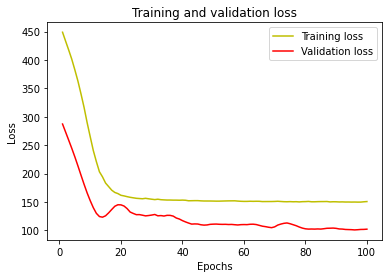


Predicted values are: 
 [[25.896511 ]
 [25.83633  ]
 [ 7.763799 ]
 [ 7.3341637]
 [25.65062  ]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 105.2736 - mean_absolute_error: 8.4610

Mean squared error from neural net: 
 105.27364349365234

Mean absolute error from neural net: 
 8.460984230041504

Predicted values are:
  [[0.00557499 0.0057546  0.00628836 0.00543019 0.00531395 0.0057693
  0.0055753  0.00623493 0.00561132 0.00522413 0.00589505 0.00633719
  0.00589441 0.00530943 0.00588722 0.00601153 0.0060654  0.00554736
  0.00590117 0.00578127 0.00581629 0.0057299  0.00542427 0.00575542
  0.00605376 0.00617749 0.00662172 0.00600882 0.00642769 0.00543591
  0.00539334 0.00575736 0.0054611  0.00611542 0.00525639 0.0059756
  0.00618017 0.00571818 0.00550687 0.0056638  0.00556418 0.00683081
  0.00619086 0.0055635  0.00554694 0.00581094 0.00577546

2/2 [==============================] - 0s 2ms/step - loss: 209.0930 - mean_absolute_error: 10.2987

Mean squared error from Convolutional neural net:  209.0929718017578

Mean absolute error from Convolutional neural net:  10.298651695251465

Mean squared error from linear regression:  336.49808908576375

Mean absolute error from linear regression:  12.149743707123902

Mean squared error using decision tree:  198.69426463157896

Mean absolute error using decision tree:  7.850736842105262

Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.00000

In [530]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 105.27364349365234

Mean absolute error from neural net: 
 8.460984230041504


Mean squared error using Random Forest:  118.26499309245271

Mean absolute error Using Random Forest:  8.835013684210532

# Predict 5 Days with 2 Weeks of Data

In [531]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [532]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [533]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26])]

In [534]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [535]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_321 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_322 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_323 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 26ms/step - loss: 435.0809 - mean_absolute_error: 14.5816 - val_loss: 271.8694 - val_mean_absolute_error: 11.2931
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 420.1245 - mean_absolute_error: 14.1000 - val_loss: 257.4986 - val_mean_absolute_error: 10.7412
Epoch 3/100
5/5 [============================

Epoch 46/100
5/5 [==============================] - 0s 6ms/step - loss: 151.6029 - mean_absolute_error: 8.7043 - val_loss: 105.0753 - val_mean_absolute_error: 7.9169
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 151.4196 - mean_absolute_error: 8.7265 - val_loss: 106.3634 - val_mean_absolute_error: 7.9888
Epoch 48/100
5/5 [==============================] - 0s 5ms/step - loss: 151.3898 - mean_absolute_error: 8.7776 - val_loss: 107.0835 - val_mean_absolute_error: 8.0349
Epoch 49/100
5/5 [==============================] - 0s 5ms/step - loss: 150.9722 - mean_absolute_error: 8.8275 - val_loss: 108.5171 - val_mean_absolute_error: 8.1211
Epoch 50/100
5/5 [==============================] - 0s 6ms/step - loss: 150.6556 - mean_absolute_error: 8.8789 - val_loss: 108.2490 - val_mean_absolute_error: 8.1077
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.0468 - mean_absolute_error: 8.9227 - val_loss: 107.4541 - val_mean_absolute_error: 8.0624
Epoc

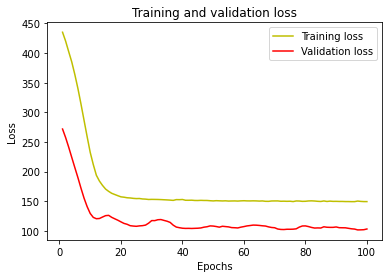


Predicted values are: 
 [[25.771126]
 [25.723528]
 [ 9.958271]
 [ 9.628405]
 [25.602339]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 133.3349 - mean_absolute_error: 8.5144

Mean squared error from neural net: 
 133.3348846435547

Mean absolute error from neural net: 
 8.514357566833496

Predicted values are:
  [[0.00605006 0.006121   0.00563653 0.00550869 0.00589572 0.00617288
  0.00537218 0.00649567 0.00576502 0.00499047 0.00592653 0.00583767
  0.00611961 0.00565772 0.00609797 0.00615601 0.00618309 0.00488186
  0.0066655  0.00602105 0.00539874 0.00576712 0.00666478 0.00513473
  0.00511246 0.00570746 0.00529743 0.00608802 0.00590506 0.0055555
  0.00530786 0.00642863 0.00532222 0.00561863 0.00639867 0.00527942
  0.00603623 0.00534496 0.00538853 0.00561473 0.00649611 0.00487892
  0.00511947 0.00627371 0.00554551 0.00651954 0.00521338 0.00

3/3 [==============================] - 0s 2ms/step - loss: 267.7458 - mean_absolute_error: 11.6811

Mean squared error from Convolutional neural net:  267.7457580566406

Mean absolute error from Convolutional neural net:  11.681137084960938

Mean squared error from linear regression:  169.91721082097612

Mean absolute error from linear regression:  9.59207799610515

Mean squared error using decision tree:  387.9542869402985

Mean absolute error using decision tree:  14.404104477611941

Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000


In [536]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 133.3348846435547

Mean absolute error from neural net: 
 8.514357566833496

 Mean squared error using Random Forest:  158.4821466998239

Mean absolute error Using Random Forest:  10.196450149253732

# Predict 1 Week with 2 weeks of data

In [537]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_day'].isin([7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])]

In [538]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 5]

In [539]:
test = test.loc[test['connectionTime_day'].isin([22,23,24,25,26,27,28])]

In [540]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [541]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_326 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_327 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_328 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 27ms/step - loss: 434.9564 - mean_absolute_error: 14.5752 - val_loss: 274.7505 - val_mean_absolute_error: 11.4283
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 415.1599 - mean_absolute_error: 13.9723 - val_loss: 261.9009 - val_mean_absolute_error: 10.9877
Epoch 3/100
5/5 [============================

Epoch 46/100
5/5 [==============================] - 0s 5ms/step - loss: 151.9087 - mean_absolute_error: 8.9166 - val_loss: 112.6837 - val_mean_absolute_error: 8.3779
Epoch 47/100
5/5 [==============================] - 0s 5ms/step - loss: 152.2848 - mean_absolute_error: 8.8926 - val_loss: 110.7602 - val_mean_absolute_error: 8.2566
Epoch 48/100
5/5 [==============================] - 0s 6ms/step - loss: 151.9223 - mean_absolute_error: 8.8697 - val_loss: 109.4573 - val_mean_absolute_error: 8.1865
Epoch 49/100
5/5 [==============================] - 0s 6ms/step - loss: 151.6532 - mean_absolute_error: 8.8673 - val_loss: 109.1548 - val_mean_absolute_error: 8.1703
Epoch 50/100
5/5 [==============================] - 0s 5ms/step - loss: 151.6122 - mean_absolute_error: 8.9071 - val_loss: 109.1186 - val_mean_absolute_error: 8.1700
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 151.8268 - mean_absolute_error: 8.9751 - val_loss: 110.6828 - val_mean_absolute_error: 8.2555
Epoc

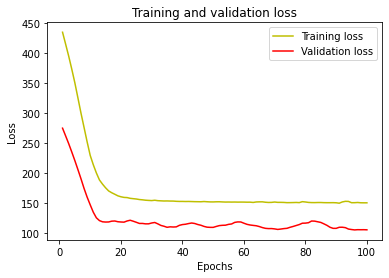


Predicted values are: 
 [[23.472803]
 [23.426685]
 [ 9.472633]
 [ 9.270383]
 [23.291286]]

Real values are: 
 29530    10.050
29531    18.952
29532     3.084
29533    20.501
29534    35.188
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 139.9669 - mean_absolute_error: 8.8325

Mean squared error from neural net: 
 139.96694946289062

Mean absolute error from neural net: 
 8.832489013671875

Predicted values are:
  [[0.00585435 0.0061989  0.00590315 0.00585325 0.00613855 0.0051413
  0.00577587 0.00572156 0.00614041 0.0057386  0.00552691 0.00587678
  0.00563719 0.00606158 0.00638129 0.00625475 0.00587075 0.00572284
  0.00558914 0.00552186 0.00524871 0.00667045 0.00611367 0.00620877
  0.00543143 0.00645236 0.00580356 0.00643373 0.00534958 0.00673702
  0.00611089 0.00558839 0.00602286 0.00567322 0.00601189 0.00587331
  0.00561705 0.00580405 0.00628564 0.00656003 0.00538953 0.00613852
  0.0053333  0.00553708 0.00625936 0.00609002 0.00571711 0.0

3/3 [==============================] - 0s 2ms/step - loss: 315.9516 - mean_absolute_error: 12.8930

Mean squared error from Convolutional neural net:  315.9515686035156

Mean absolute error from Convolutional neural net:  12.893013000488281

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975

Mean squared error using decision tree:  374.6886319139785

Mean absolute error using decision tree:  13.38948387096774

Mean squared error using Random Forest:  187.209413674942

Mean absolute error Using Random Forest:  10.53328107526882

 The features ranking by importance to the RF Model

 doneChargingTime            0.272714
disconnectTime              0.247277
connectionTime              0.240627
spaceID                     0.094457
connectionTime_dayofweek    0.090159
connectionTime_day          0.047802
connectionTime_week         0.006964
_id                         0.000000
siteID                      0.000000
con

In [542]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 139.96694946289062

Mean absolute error from neural net: 
 8.832489013671875

Mean squared error from linear regression:  142.27094868893911

Mean absolute error from linear regression:  9.24767487246975


# Predict 1 Day with 1 Month of Data

In [543]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [544]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [545]:
test = test.loc[test['connectionTime_day'].isin([1])]

In [546]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [547]:
x_trainScaled.shape

(253, 11)

In [548]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_331 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_332 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_333 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 244.5534 - mean_absolute_error: 10.6657 - val_loss: 300.8907 - val_mean_absolute_error: 12.4247
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 230.2990 - mean_absolute_error: 10.0780 - val_loss: 278.1577 - val_mean_absolute_error: 11.6425
Epoch 3/100
7/7 [============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 96.7572 - mean_absolute_error: 7.0463 - val_loss: 141.6825 - val_mean_absolute_error: 10.6066
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 96.7955 - mean_absolute_error: 7.0166 - val_loss: 138.5036 - val_mean_absolute_error: 10.5092
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 96.7580 - mean_absolute_error: 7.0129 - val_loss: 138.8484 - val_mean_absolute_error: 10.5197
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8215 - mean_absolute_error: 7.0388 - val_loss: 141.3900 - val_mean_absolute_error: 10.5922
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.6985 - mean_absolute_error: 7.0714 - val_loss: 140.6547 - val_mean_absolute_error: 10.5466
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 96.6383 - mean_absolute_error: 7.1142 - val_loss: 148.0417 - val_mean_absolute_error: 10.8366
Epoc

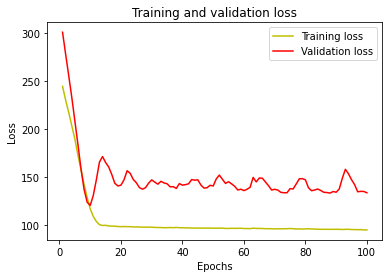


Predicted values are: 
 [[15.471088]
 [15.504513]
 [ 5.180152]
 [ 6.59173 ]
 [17.205647]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 160.7448 - mean_absolute_error: 7.4367

Mean squared error from neural net: 
 160.7447967529297

Mean absolute error from neural net: 
 7.436678886413574

Predicted values are:
  [[0.00375613 0.00383575 0.00413369 ... 0.00415776 0.00414581 0.0039448 ]
 [0.00376233 0.00384286 0.00413271 ... 0.0041568  0.00414842 0.0039439 ]
 [0.00375143 0.00389865 0.00389352 ... 0.00408803 0.00418242 0.0040525 ]
 [0.00396735 0.00400847 0.00398678 ... 0.00404189 0.00415369 0.00397191]
 [0.00392972 0.00378698 0.00413348 ... 0.00420703 0.00415797 0.0039215 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=============================

In [549]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 160.7447967529297

Mean absolute error from neural net: 
 7.436678886413574

 Mean squared error from Convolutional neural net:  375.9288024902344

Mean absolute error from Convolutional neural net:  12.156847953796387

# Predict 3 Days with 1 month of Data

In [550]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [551]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [552]:
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [553]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [554]:
x_trainScaled.shape

(253, 11)

In [555]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_337 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_338 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 20ms/step - loss: 252.5565 - mean_absolute_error: 11.1388 - val_loss: 311.6177 - val_mean_absolute_error: 12.7117
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 241.8524 - mean_absolute_error: 10.6025 - val_loss: 297.9920 - val_mean_absolute_error: 12.2177
Epoch 3/100
7/7 [============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9747 - mean_absolute_error: 7.0170 - val_loss: 125.8163 - val_mean_absolute_error: 9.9507
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0080 - mean_absolute_error: 7.0535 - val_loss: 129.9630 - val_mean_absolute_error: 10.1324
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9203 - mean_absolute_error: 7.0592 - val_loss: 131.1007 - val_mean_absolute_error: 10.1844
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8753 - mean_absolute_error: 7.0788 - val_loss: 131.3481 - val_mean_absolute_error: 10.1949
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8417 - mean_absolute_error: 7.0935 - val_loss: 129.3347 - val_mean_absolute_error: 10.1063
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8234 - mean_absolute_error: 7.0407 - val_loss: 124.1707 - val_mean_absolute_error: 9.8710
Epoch 

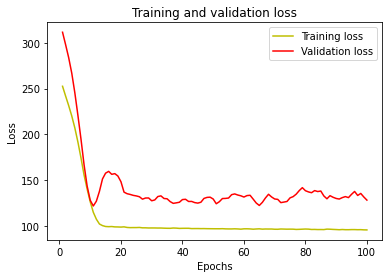


Predicted values are: 
 [[13.246907]
 [13.155936]
 [ 6.330918]
 [ 5.95192 ]
 [11.353136]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 213.6458 - mean_absolute_error: 9.3925

Mean squared error from neural net: 
 213.64584350585938

Mean absolute error from neural net: 
 9.39246940612793

Predicted values are:
  [[0.00383131 0.00349868 0.00409227 ... 0.00402451 0.00377573 0.00344231]
 [0.00383079 0.00350058 0.0040918  ... 0.00402418 0.0037787  0.00344727]
 [0.00420895 0.00383612 0.00415724 ... 0.00385544 0.00374756 0.00371259]
 [0.00415013 0.00380818 0.00416791 ... 0.00383636 0.00381219 0.00379517]
 [0.00385199 0.00355292 0.00410822 ... 0.00398828 0.00383259 0.00359494]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=============================

In [556]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 213.64584350585938

Mean absolute error from neural net: 
 9.39246940612793

 Mean squared error using decision tree:  186.34709148387097

Mean absolute error using decision tree:  8.564


# Predict 5 Days with 1 Month of Data

In [557]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [558]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [559]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [560]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [561]:
x_trainScaled.shape

(253, 11)

In [562]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_341 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_342 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 239.2815 - mean_absolute_error: 10.4573 - val_loss: 284.2016 - val_mean_absolute_error: 11.9153
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 222.3202 - mean_absolute_error: 9.7506 - val_loss: 255.4854 - val_mean_absolute_error: 11.0387
Epoch 3/100
7/7 [=============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8559 - mean_absolute_error: 7.0319 - val_loss: 145.7740 - val_mean_absolute_error: 10.7849
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 97.1438 - mean_absolute_error: 7.0621 - val_loss: 144.5311 - val_mean_absolute_error: 10.7484
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 97.1675 - mean_absolute_error: 7.0851 - val_loss: 148.0359 - val_mean_absolute_error: 10.8771
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8907 - mean_absolute_error: 7.0362 - val_loss: 145.3958 - val_mean_absolute_error: 10.7894
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8947 - mean_absolute_error: 6.9991 - val_loss: 142.1086 - val_mean_absolute_error: 10.6741
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0600 - mean_absolute_error: 6.9786 - val_loss: 138.6758 - val_mean_absolute_error: 10.5387
Epoc

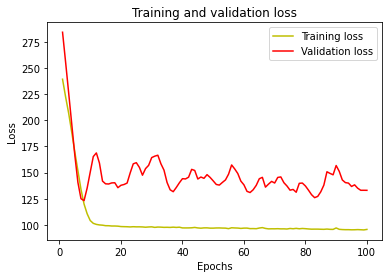


Predicted values are: 
 [[12.904867 ]
 [12.88207  ]
 [ 5.914713 ]
 [ 5.9671416]
 [12.473935 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 198.3243 - mean_absolute_error: 9.6775

Mean squared error from neural net: 
 198.32432556152344

Mean absolute error from neural net: 
 9.677536964416504

Predicted values are:
  [[0.00414654 0.00406036 0.003736   ... 0.00422145 0.00384581 0.00381329]
 [0.0041453  0.0040574  0.00373648 ... 0.00421871 0.00384668 0.00381471]
 [0.00407762 0.00412087 0.00399339 ... 0.00401307 0.00393492 0.00375187]
 [0.00408919 0.00404957 0.00400363 ... 0.00398075 0.00394616 0.00377888]
 [0.00411632 0.0039816  0.00374748 ... 0.00415043 0.00387596 0.00384859]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [========================

In [563]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 198.32432556152344

Mean absolute error from neural net: 
 9.677536964416504


Mean squared error using Random Forest:  220.6186052555203

Mean absolute error Using Random Forest:  11.660016579549948

# Predict 1 Week with 1 Month of Data

In [564]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'] == 3]

In [565]:
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]

In [566]:
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [567]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [568]:
x_trainScaled.shape

(253, 11)

In [569]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_346 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_347 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_348 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 244.5868 - mean_absolute_error: 10.7324 - val_loss: 287.9255 - val_mean_absolute_error: 12.0328
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 229.7113 - mean_absolute_error: 10.0991 - val_loss: 262.3501 - val_mean_absolute_error: 11.2755
Epoch 3/100
7/7 [============================

Epoch 46/100
7/7 [==============================] - 0s 4ms/step - loss: 97.1626 - mean_absolute_error: 7.1578 - val_loss: 144.2634 - val_mean_absolute_error: 10.6851
Epoch 47/100
7/7 [==============================] - 0s 4ms/step - loss: 97.2154 - mean_absolute_error: 7.1508 - val_loss: 138.4586 - val_mean_absolute_error: 10.4535
Epoch 48/100
7/7 [==============================] - 0s 4ms/step - loss: 96.8267 - mean_absolute_error: 7.0598 - val_loss: 136.2420 - val_mean_absolute_error: 10.3652
Epoch 49/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9700 - mean_absolute_error: 7.0017 - val_loss: 137.4807 - val_mean_absolute_error: 10.4130
Epoch 50/100
7/7 [==============================] - 0s 4ms/step - loss: 96.9145 - mean_absolute_error: 6.9828 - val_loss: 136.1793 - val_mean_absolute_error: 10.3634
Epoch 51/100
7/7 [==============================] - 0s 4ms/step - loss: 97.0208 - mean_absolute_error: 6.9697 - val_loss: 134.2682 - val_mean_absolute_error: 10.2799
Epoc

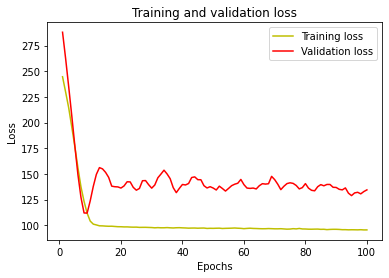


Predicted values are: 
 [[16.095055 ]
 [16.079247 ]
 [ 8.155408 ]
 [ 7.6106467]
 [15.774546 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 166.5868 - mean_absolute_error: 9.0340

Mean squared error from neural net: 
 166.5867919921875

Mean absolute error from neural net: 
 9.034040451049805

Predicted values are:
  [[0.00378966 0.00392088 0.00411596 ... 0.00377299 0.00388746 0.00389995]
 [0.00379132 0.00392232 0.00411627 ... 0.0037737  0.00388772 0.0039001 ]
 [0.00363732 0.00379237 0.00414472 ... 0.00373509 0.00404934 0.00399623]
 [0.0036719  0.0038229  0.00412889 ... 0.00376884 0.00400677 0.00398471]
 [0.00382842 0.00395589 0.00411957 ... 0.00379445 0.00389856 0.00390361]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [=========================

In [570]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 166.5867919921875

Mean absolute error from neural net: 
 9.034040451049805

 Mean squared error from linear regression:  218.3835207200644

Mean absolute error from linear regression:  10.310513898451116

# Predict 1 Day with 2 Months of Data

In [571]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1])]

In [572]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [573]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_351 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_352 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_353 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 247.5524 - mean_absolute_error: 9.9944 - val_loss: 285.1752 - val_mean_absolute_error: 10.6821
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 167.5041 - mean_absolute_error: 7.9988 - val_loss: 181.3238 - val_mean_absolute_error: 8.8836
Epoch 3/100
27/27 [==========================

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 104.6707 - mean_absolute_error: 7.2236 - val_loss: 140.8838 - val_mean_absolute_error: 8.8673
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 104.5329 - mean_absolute_error: 7.2040 - val_loss: 142.5491 - val_mean_absolute_error: 8.7547
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 105.3717 - mean_absolute_error: 6.8732 - val_loss: 141.3720 - val_mean_absolute_error: 8.8106
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 103.5816 - mean_absolute_error: 7.1965 - val_loss: 147.3716 - val_mean_absolute_error: 9.1894
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.4822 - mean_absolute_error: 7.0311 - val_loss: 141.9332 - val_mean_absolute_error: 8.8113
Epoch 99/100
27/27 [==============================] - 0s 3ms/step - loss: 103.3448 - mean_absolute_error: 7.0279 - val_loss: 138.5541 - val_mean_absolute_error:

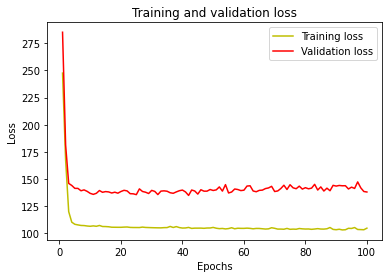


Predicted values are: 
 [[9.110376 ]
 [9.0657625]
 [8.071296 ]
 [2.950948 ]
 [2.4859447]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 16ms/step - loss: 83.2811 - mean_absolute_error: 6.6215

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Predicted values are:
  [[0.00092864 0.00091926 0.00095532 ... 0.0009944  0.00090354 0.00091722]
 [0.0009274  0.00091801 0.0009541  ... 0.0009941  0.00090448 0.00091842]
 [0.0009299  0.00092351 0.00095429 ... 0.00098967 0.00091066 0.0009217 ]
 [0.000946   0.00094514 0.00094846 ... 0.00097188 0.00093976 0.00094339]
 [0.00095269 0.00095084 0.00095436 ... 0.00095996 0.00094143 0.00095593]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
1/1 [==============================

In [574]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Predict 3 Days with 2 Months of Data

In [575]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [576]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [577]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_356 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_357 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_358 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 252.1134 - mean_absolute_error: 10.0538 - val_loss: 277.3725 - val_mean_absolute_error: 10.4537
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 174.5682 - mean_absolute_error: 8.2637 - val_loss: 170.6506 - val_mean_absolute_error: 9.1337
Epoch 3/100
27/27 [=========================

Epoch 94/100
27/27 [==============================] - 0s 3ms/step - loss: 103.4827 - mean_absolute_error: 7.0135 - val_loss: 147.1849 - val_mean_absolute_error: 9.2796
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.8087 - mean_absolute_error: 7.2008 - val_loss: 149.1769 - val_mean_absolute_error: 9.3183
Epoch 96/100
27/27 [==============================] - 0s 1ms/step - loss: 103.5822 - mean_absolute_error: 7.0493 - val_loss: 146.3677 - val_mean_absolute_error: 9.2390
Epoch 97/100
27/27 [==============================] - 0s 1ms/step - loss: 103.7060 - mean_absolute_error: 7.0812 - val_loss: 142.0999 - val_mean_absolute_error: 8.9549
Epoch 98/100
27/27 [==============================] - 0s 1ms/step - loss: 104.2578 - mean_absolute_error: 6.9518 - val_loss: 144.5327 - val_mean_absolute_error: 9.0099
Epoch 99/100
27/27 [==============================] - 0s 1ms/step - loss: 103.6141 - mean_absolute_error: 7.1507 - val_loss: 142.9820 - val_mean_absolute_error:

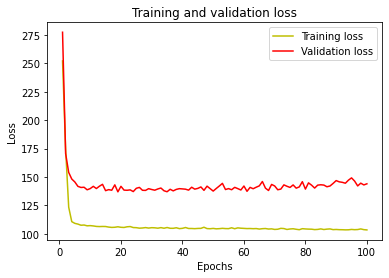


Predicted values are: 
 [[10.579198]
 [10.51633 ]
 [10.224273]
 [ 8.681141]
 [ 8.598397]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 102.6583 - mean_absolute_error: 7.4130

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Predicted values are:
  [[0.00088684 0.00096102 0.00091126 ... 0.00096076 0.00094269 0.00097486]
 [0.00088695 0.00096088 0.00091151 ... 0.00096052 0.00094272 0.00097481]
 [0.00088988 0.00096088 0.00091282 ... 0.00095936 0.00094277 0.00097389]
 [0.0009072  0.00095999 0.00091995 ... 0.00095295 0.00094358 0.00096871]
 [0.0009144  0.00095892 0.0009217  ... 0.00095255 0.00094476 0.00096829]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [============================

In [578]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483


# Predict 5 Days with 2 Months of Data

In [579]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [580]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [581]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_361 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_362 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_363 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 255.9215 - mean_absolute_error: 10.1471 - val_loss: 302.4780 - val_mean_absolute_error: 11.1000
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 179.4558 - mean_absolute_error: 8.2942 - val_loss: 196.0264 - val_mean_absolute_error: 9.0305
Epoch 3/100
27/27 [=========================

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.7220 - mean_absolute_error: 7.0446 - val_loss: 146.3692 - val_mean_absolute_error: 9.1429
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.7689 - mean_absolute_error: 7.1078 - val_loss: 139.2486 - val_mean_absolute_error: 8.6962
Epoch 96/100
27/27 [==============================] - 0s 3ms/step - loss: 103.2616 - mean_absolute_error: 7.1556 - val_loss: 141.8742 - val_mean_absolute_error: 8.8347
Epoch 97/100
27/27 [==============================] - 0s 3ms/step - loss: 103.2693 - mean_absolute_error: 7.0097 - val_loss: 146.3215 - val_mean_absolute_error: 9.2158
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.4637 - mean_absolute_error: 7.0144 - val_loss: 146.0141 - val_mean_absolute_error: 9.1574
Epoch 99/100
27/27 [==============================] - 0s 2ms/step - loss: 103.5580 - mean_absolute_error: 7.1280 - val_loss: 141.9244 - val_mean_absolute_error:

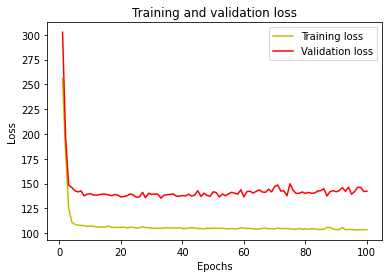


Predicted values are: 
 [[9.658259 ]
 [9.6387615]
 [9.506989 ]
 [8.768042 ]
 [8.683549 ]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 117.1256 - mean_absolute_error: 7.5161

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945

Predicted values are:
  [[0.00089678 0.00100537 0.0009567  ... 0.00098396 0.00097694 0.00096664]
 [0.0008969  0.00100551 0.00095683 ... 0.00098433 0.00097703 0.00096692]
 [0.00089851 0.00100409 0.00095674 ... 0.00098305 0.00097657 0.00096613]
 [0.00090744 0.00099606 0.00095672 ... 0.00097615 0.00097413 0.0009621 ]
 [0.00091115 0.00099194 0.00095486 ... 0.00097108 0.00097321 0.00095842]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
3/3 [=============================

In [582]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Predict 1 Week with 2 Months of Data

In [583]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([7, 8])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 9]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [584]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [585]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_366 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_367 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_368 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 243.4818 - mean_absolute_error: 9.7485 - val_loss: 276.1281 - val_mean_absolute_error: 10.4390
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 164.6676 - mean_absolute_error: 7.9861 - val_loss: 171.0055 - val_mean_absolute_error: 8.9743
Epoch 3/100
27/27 [==========================

Epoch 94/100
27/27 [==============================] - 0s 2ms/step - loss: 103.5435 - mean_absolute_error: 6.9729 - val_loss: 145.3846 - val_mean_absolute_error: 8.9400
Epoch 95/100
27/27 [==============================] - 0s 2ms/step - loss: 103.5007 - mean_absolute_error: 7.1106 - val_loss: 145.2848 - val_mean_absolute_error: 9.1027
Epoch 96/100
27/27 [==============================] - 0s 2ms/step - loss: 103.4161 - mean_absolute_error: 7.0868 - val_loss: 148.6093 - val_mean_absolute_error: 9.3568
Epoch 97/100
27/27 [==============================] - 0s 2ms/step - loss: 104.0089 - mean_absolute_error: 6.9550 - val_loss: 146.5865 - val_mean_absolute_error: 9.1267
Epoch 98/100
27/27 [==============================] - 0s 2ms/step - loss: 103.2956 - mean_absolute_error: 7.0866 - val_loss: 144.8014 - val_mean_absolute_error: 9.0188
Epoch 99/100
27/27 [==============================] - 0s 2ms/step - loss: 103.3340 - mean_absolute_error: 7.0321 - val_loss: 148.1618 - val_mean_absolute_error:

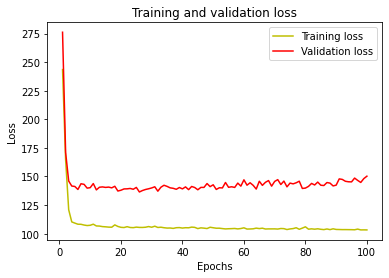


Predicted values are: 
 [[6.084726 ]
 [6.061895 ]
 [5.9783025]
 [5.5449934]
 [5.540392 ]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [==============================] - 0s 2ms/step - loss: 104.1581 - mean_absolute_error: 6.9463

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

Predicted values are:
  [[0.00093757 0.00097698 0.00100318 ... 0.00090466 0.00098604 0.00092603]
 [0.00093751 0.0009771  0.00100312 ... 0.00090456 0.00098609 0.000926  ]
 [0.00093791 0.00097687 0.00100257 ... 0.00090538 0.00098522 0.000926  ]
 [0.00093996 0.00097494 0.00099945 ... 0.0009091  0.00098039 0.00092525]
 [0.00094125 0.00097321 0.00099861 ... 0.00091053 0.00097837 0.00092474]]

Real values are: 
 31131     0.901
31132     2.101
31133     3.152
31134     5.894
31135    31.942
Name: kWhDelivered, dtype: float64
5/5 [=============================

In [586]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829



# Predict 1 Day with 3 months

In [587]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [588]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [589]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_371 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_372 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_373 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 8ms/step - loss: 247.4542 - mean_absolute_error: 11.1172 - val_loss: 273.5917 - val_mean_absolute_error: 11.3966
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 209.0289 - mean_absolute_error: 9.6954 - val_loss: 234.3797 - val_mean_absolute_error: 10.1545
Epoch 3/100
16/16 [========================

16/16 [==============================] - 0s 2ms/step - loss: 70.0956 - mean_absolute_error: 6.0854 - val_loss: 107.3746 - val_mean_absolute_error: 7.3288
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5605 - mean_absolute_error: 6.0353 - val_loss: 112.2365 - val_mean_absolute_error: 7.3250
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 70.6969 - mean_absolute_error: 6.0927 - val_loss: 108.1155 - val_mean_absolute_error: 7.4513
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 69.9546 - mean_absolute_error: 6.0947 - val_loss: 110.9892 - val_mean_absolute_error: 7.3048
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 69.9781 - mean_absolute_error: 6.1181 - val_loss: 109.8810 - val_mean_absolute_error: 7.3447
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 69.5239 - mean_absolute_error: 5.9694 - val_loss: 109.6178 - val_mean_absolute_error: 7.3436
Epoch 100/1

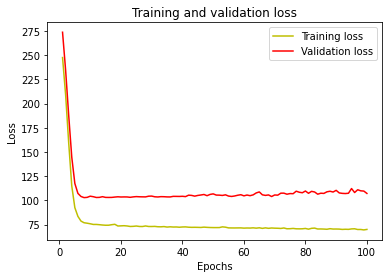


Predicted values are: 
 [[21.303204 ]
 [21.337067 ]
 [ 3.3062053]
 [ 5.794284 ]
 [21.739788 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 140.7057 - mean_absolute_error: 7.8199

Mean squared error from neural net: 
 140.70570373535156

Mean absolute error from neural net: 
 7.819906711578369

Predicted values are:
  [[0.00159383 0.00160373 0.00148117 ... 0.00168528 0.00151922 0.00165171]
 [0.00159425 0.00160384 0.00148475 ... 0.00168243 0.00152009 0.00165059]
 [0.00160513 0.00162744 0.00153545 ... 0.00168789 0.00158803 0.00163092]
 [0.00162476 0.00162267 0.00158707 ... 0.00163425 0.00160046 0.00166501]
 [0.0016035  0.00160902 0.00152211 ... 0.0016444  0.00155638 0.00161113]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [590]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 140.70570373535156

Mean absolute error from neural net: 
 7.819906711578369

Mean squared error using decision tree:  130.75000129999998

Mean absolute error using decision tree:  6.7923

# Predict 3 Days with 3 months

In [591]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [592]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [593]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_376 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_377 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_378 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 10ms/step - loss: 246.7000 - mean_absolute_error: 11.0615 - val_loss: 275.8982 - val_mean_absolute_error: 11.4997
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 204.1168 - mean_absolute_error: 9.5127 - val_loss: 237.9940 - val_mean_absolute_error: 10.2679
Epoch 3/100
16/16 [=======================

16/16 [==============================] - 0s 2ms/step - loss: 69.9511 - mean_absolute_error: 6.0799 - val_loss: 107.3938 - val_mean_absolute_error: 7.5607
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 69.5916 - mean_absolute_error: 6.0337 - val_loss: 108.2015 - val_mean_absolute_error: 7.5710
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 69.4515 - mean_absolute_error: 6.0567 - val_loss: 108.8452 - val_mean_absolute_error: 7.5558
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 69.4977 - mean_absolute_error: 6.0742 - val_loss: 108.5036 - val_mean_absolute_error: 7.5910
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 69.5331 - mean_absolute_error: 6.0514 - val_loss: 109.1653 - val_mean_absolute_error: 7.5812
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 69.7080 - mean_absolute_error: 6.0600 - val_loss: 108.9397 - val_mean_absolute_error: 7.5092
Epoch 100/1

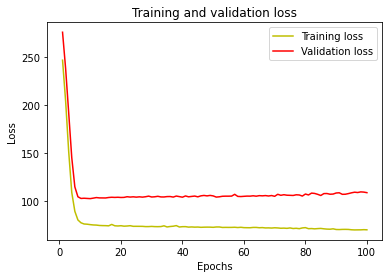


Predicted values are: 
 [[19.880907 ]
 [19.83825  ]
 [ 3.7607574]
 [ 3.5986776]
 [18.958563 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 187.8617 - mean_absolute_error: 8.8690

Mean squared error from neural net: 
 187.8616943359375

Mean absolute error from neural net: 
 8.869044303894043

Predicted values are:
  [[0.00165936 0.00159148 0.00164794 ... 0.00158844 0.0015924  0.00164888]
 [0.00165973 0.00159095 0.00164827 ... 0.0015885  0.00159322 0.00164931]
 [0.00174487 0.00152677 0.00173962 ... 0.00159559 0.00160528 0.00163244]
 [0.00170959 0.00154145 0.00173605 ... 0.00161566 0.00162844 0.00163655]
 [0.00166379 0.00158553 0.00165519 ... 0.00159851 0.00161565 0.00166662]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [========================

In [594]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 187.8616943359375

Mean absolute error from neural net: 
 8.869044303894043

 Mean squared error using Random Forest:  183.2863459959755

Mean absolute error Using Random Forest:  10.364935468369174

# Predict 5 Days with 3 months

In [595]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [596]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [597]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_381 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_382 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_383 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 8ms/step - loss: 235.8348 - mean_absolute_error: 10.6045 - val_loss: 257.5231 - val_mean_absolute_error: 10.8708
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 188.7382 - mean_absolute_error: 9.0245 - val_loss: 211.3951 - val_mean_absolute_error: 9.5858
Epoch 3/100
16/16 [=========================

16/16 [==============================] - 0s 2ms/step - loss: 70.5707 - mean_absolute_error: 6.1075 - val_loss: 104.5758 - val_mean_absolute_error: 7.3615
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 70.6107 - mean_absolute_error: 6.0694 - val_loss: 105.5928 - val_mean_absolute_error: 7.3234
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 71.0509 - mean_absolute_error: 6.1709 - val_loss: 104.5347 - val_mean_absolute_error: 7.4157
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 70.8686 - mean_absolute_error: 6.0326 - val_loss: 105.5656 - val_mean_absolute_error: 7.3519
Epoch 98/100
16/16 [==============================] - 0s 2ms/step - loss: 70.8791 - mean_absolute_error: 6.1060 - val_loss: 103.8312 - val_mean_absolute_error: 7.5338
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5700 - mean_absolute_error: 6.1438 - val_loss: 105.9567 - val_mean_absolute_error: 7.3201
Epoch 100/1

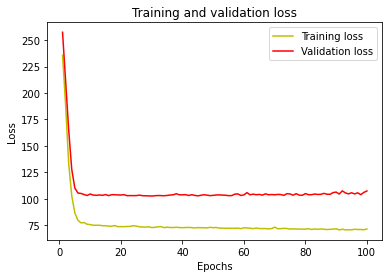


Predicted values are: 
 [[16.611298 ]
 [16.635986 ]
 [ 4.8962054]
 [ 5.1901503]
 [17.190544 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 160.4489 - mean_absolute_error: 8.0132

Mean squared error from neural net: 
 160.44891357421875

Mean absolute error from neural net: 
 8.013179779052734

Predicted values are:
  [[0.00165528 0.0015987  0.00169267 ... 0.00157404 0.0015852  0.00175086]
 [0.00165506 0.00159887 0.0016919  ... 0.00157458 0.00158616 0.00174979]
 [0.00160207 0.00163629 0.00170608 ... 0.0016103  0.00161817 0.00175828]
 [0.00160705 0.00165261 0.00168628 ... 0.00161549 0.00163519 0.00173875]
 [0.00165264 0.00160336 0.00167464 ... 0.00159027 0.00161129 0.00172902]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [========================

In [598]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 160.44891357421875

Mean absolute error from neural net: 
 8.013179779052734

Mean squared error using Random Forest:  163.33505718087187

Mean absolute error Using Random Forest:  10.224571321158745

# Predict 1 Week with 3 months

In [599]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [600]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [601]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_386 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_387 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_388 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 0s 8ms/step - loss: 252.4331 - mean_absolute_error: 11.3025 - val_loss: 274.5429 - val_mean_absolute_error: 11.4836
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 216.9844 - mean_absolute_error: 9.9048 - val_loss: 235.1574 - val_mean_absolute_error: 10.1941
Epoch 3/100
16/16 [========================

16/16 [==============================] - 0s 2ms/step - loss: 70.8543 - mean_absolute_error: 6.1091 - val_loss: 104.0928 - val_mean_absolute_error: 7.3196
Epoch 95/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5825 - mean_absolute_error: 6.0477 - val_loss: 104.9959 - val_mean_absolute_error: 7.3031
Epoch 96/100
16/16 [==============================] - 0s 2ms/step - loss: 71.6621 - mean_absolute_error: 6.2193 - val_loss: 103.8361 - val_mean_absolute_error: 7.3635
Epoch 97/100
16/16 [==============================] - 0s 2ms/step - loss: 70.5276 - mean_absolute_error: 6.0977 - val_loss: 104.7394 - val_mean_absolute_error: 7.3340
Epoch 98/100
16/16 [==============================] - 0s 4ms/step - loss: 70.7287 - mean_absolute_error: 6.0578 - val_loss: 105.6475 - val_mean_absolute_error: 7.2713
Epoch 99/100
16/16 [==============================] - 0s 2ms/step - loss: 70.2541 - mean_absolute_error: 6.0796 - val_loss: 106.1013 - val_mean_absolute_error: 7.3223
Epoch 100/1

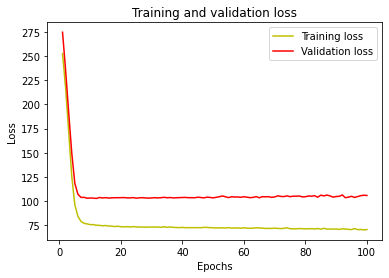


Predicted values are: 
 [[21.21951 ]
 [21.230364]
 [ 5.331443]
 [ 5.373581]
 [21.570837]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 139.3793 - mean_absolute_error: 7.5719

Mean squared error from neural net: 
 139.3793182373047

Mean absolute error from neural net: 
 7.571944236755371

Predicted values are:
  [[0.00181279 0.00154283 0.00167649 ... 0.00167632 0.00172734 0.00156806]
 [0.00181234 0.00154303 0.00167613 ... 0.00167562 0.00172677 0.00156846]
 [0.00173621 0.00160855 0.00173054 ... 0.00171365 0.00169922 0.0014891 ]
 [0.00173387 0.00162076 0.00171976 ... 0.0016953  0.00168294 0.00149944]
 [0.00180203 0.00154785 0.00166866 ... 0.00165999 0.00171352 0.00157806]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================

In [602]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 139.3793182373047

Mean absolute error from neural net: 
 7.571944236755371

 Mean squared error using Random Forest:  159.6135360726889

Mean absolute error Using Random Forest:  8.76255422973079

# Predict 1 Day with 6 months

In [603]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'] == 1]

In [604]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [605]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_391 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_392 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_393 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 1s 3ms/step - loss: 246.3156 - mean_absolute_error: 10.2759 - val_loss: 187.1398 - val_mean_absolute_error: 8.5512
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 132.6866 - mean_absolute_error: 7.8606 - val_loss: 132.9688 - val_mean_absolute_error: 9.5986
Epoch 3/100
43/43 [==========================

Epoch 94/100
43/43 [==============================] - 0s 2ms/step - loss: 106.4944 - mean_absolute_error: 7.2784 - val_loss: 107.6790 - val_mean_absolute_error: 7.4339
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.8406 - mean_absolute_error: 7.2414 - val_loss: 111.7591 - val_mean_absolute_error: 8.0272
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3749 - mean_absolute_error: 7.2686 - val_loss: 109.4285 - val_mean_absolute_error: 7.7092
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.5705 - mean_absolute_error: 7.1586 - val_loss: 112.4672 - val_mean_absolute_error: 8.1102
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3862 - mean_absolute_error: 7.2789 - val_loss: 109.3179 - val_mean_absolute_error: 7.7556
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 105.2193 - mean_absolute_error: 7.1667 - val_loss: 111.0029 - val_mean_absolute_error:

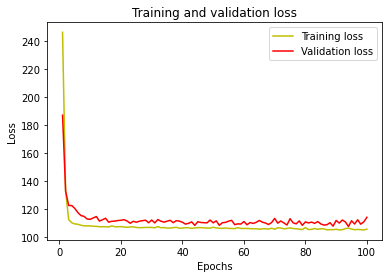


Predicted values are: 
 [[20.787485 ]
 [20.788145 ]
 [ 6.8825564]
 [ 7.0622277]
 [23.713633 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 137.4306 - mean_absolute_error: 8.4274

Mean squared error from neural net: 
 137.43057250976562

Mean absolute error from neural net: 
 8.427358627319336

Predicted values are:
  [[0.00056316 0.00059938 0.00059567 ... 0.00059285 0.00059722 0.00058892]
 [0.00056434 0.00059925 0.00059539 ... 0.00059244 0.00059751 0.00058879]
 [0.00057011 0.00057707 0.00059743 ... 0.00058522 0.00058269 0.00058632]
 [0.00057328 0.00059266 0.00059764 ... 0.00058981 0.00058584 0.00057624]
 [0.00056851 0.00058959 0.00059558 ... 0.00058464 0.00059809 0.00059014]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [=======================

In [606]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 137.43057250976562

Mean absolute error from neural net: 
 8.427358627319336


Mean squared error using Random Forest:  139.48872427732

Mean absolute error Using Random Forest:  8.705460000000002

# Predict 3 Days with 6 months

In [607]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [608]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [609]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_396 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_397 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_398 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 4ms/step - loss: 263.9619 - mean_absolute_error: 10.8085 - val_loss: 198.5184 - val_mean_absolute_error: 9.0200
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 138.8577 - mean_absolute_error: 8.1132 - val_loss: 151.4373 - val_mean_absolute_error: 10.5734
Epoch 3/100
43/43 [=========================

Epoch 94/100
43/43 [==============================] - 0s 2ms/step - loss: 105.3506 - mean_absolute_error: 7.2295 - val_loss: 110.3916 - val_mean_absolute_error: 7.1794
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3997 - mean_absolute_error: 7.2267 - val_loss: 109.1629 - val_mean_absolute_error: 7.4702
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7750 - mean_absolute_error: 7.2204 - val_loss: 108.6053 - val_mean_absolute_error: 7.3023
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.1983 - mean_absolute_error: 7.2015 - val_loss: 110.0548 - val_mean_absolute_error: 7.3012
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.6391 - mean_absolute_error: 7.1444 - val_loss: 109.9482 - val_mean_absolute_error: 7.8381
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7689 - mean_absolute_error: 7.2198 - val_loss: 109.2827 - val_mean_absolute_error:

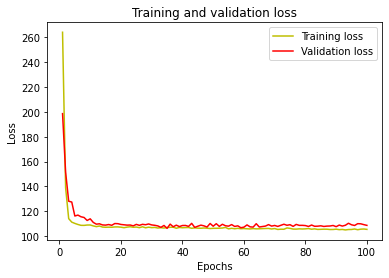


Predicted values are: 
 [[16.012926]
 [15.974239]
 [ 8.423554]
 [ 7.499452]
 [15.279444]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 168.5415 - mean_absolute_error: 8.7203

Mean squared error from neural net: 
 168.54148864746094

Mean absolute error from neural net: 
 8.720255851745605

Predicted values are:
  [[0.00056229 0.00057745 0.00058828 ... 0.00056477 0.0006053  0.00058256]
 [0.00056265 0.00057762 0.00058829 ... 0.00056515 0.00060525 0.00058281]
 [0.00055683 0.00058334 0.00057528 ... 0.00057069 0.00059677 0.00057825]
 [0.00056822 0.00058099 0.00057606 ... 0.00057678 0.00059964 0.00058764]
 [0.00056999 0.0005808  0.0005881  ... 0.00057307 0.00060477 0.00058763]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
1/1 [============================

In [610]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 168.54148864746094

Mean absolute error from neural net: 
 8.720255851745605

 Mean squared error using Random Forest:  278.053234980616

Mean absolute error Using Random Forest:  14.620022903225802


# Predict 5 Days with 6 months

In [611]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [612]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [613]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_401 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_402 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_403 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 3ms/step - loss: 254.5503 - mean_absolute_error: 10.6179 - val_loss: 179.4493 - val_mean_absolute_error: 8.3970
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 133.6327 - mean_absolute_error: 7.8775 - val_loss: 133.0592 - val_mean_absolute_error: 9.5840
Epoch 3/100
43/43 [==========================

Epoch 94/100
43/43 [==============================] - 0s 1ms/step - loss: 105.9052 - mean_absolute_error: 7.2295 - val_loss: 110.1920 - val_mean_absolute_error: 7.8938
Epoch 95/100
43/43 [==============================] - 0s 2ms/step - loss: 105.8628 - mean_absolute_error: 7.2030 - val_loss: 113.5462 - val_mean_absolute_error: 8.2040
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 105.4549 - mean_absolute_error: 7.2162 - val_loss: 110.0340 - val_mean_absolute_error: 7.8717
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.9584 - mean_absolute_error: 7.2141 - val_loss: 110.3289 - val_mean_absolute_error: 7.9175
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.9945 - mean_absolute_error: 7.2481 - val_loss: 110.6214 - val_mean_absolute_error: 7.9512
Epoch 99/100
43/43 [==============================] - 0s 1ms/step - loss: 105.5842 - mean_absolute_error: 7.2399 - val_loss: 110.2109 - val_mean_absolute_error:

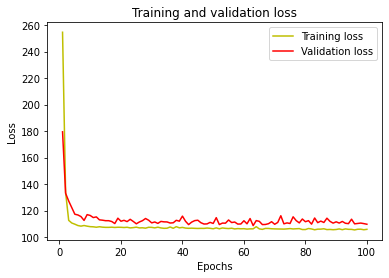


Predicted values are: 
 [[17.590939 ]
 [17.560059 ]
 [ 7.4571905]
 [ 7.257626 ]
 [16.839668 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [==============================] - 0s 2ms/step - loss: 165.6179 - mean_absolute_error: 8.6617

Mean squared error from neural net: 
 165.61785888671875

Mean absolute error from neural net: 
 8.66168212890625

Predicted values are:
  [[0.00057703 0.00060343 0.00060147 ... 0.00059934 0.00057688 0.00059863]
 [0.0005772  0.00060327 0.00060152 ... 0.00059921 0.00057699 0.00059879]
 [0.00058164 0.0006231  0.00059675 ... 0.00062201 0.00058309 0.00058735]
 [0.00058246 0.00062187 0.00059895 ... 0.00061313 0.0005838  0.00058968]
 [0.00058101 0.00060064 0.00060272 ... 0.00059716 0.00057908 0.00060219]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
2/2 [=========================

In [614]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 165.61785888671875

Mean absolute error from neural net: 
 8.66168212890625

 Mean squared error using Random Forest:  272.07574671006506

Mean absolute error Using Random Forest:  14.128006579549945


# Predict 1 Week with 6 months

In [615]:
train = df.loc[df['connectionTime_year'] == 2021]
train = train.loc[train['connectionTime_month'].isin([1, 2, 3, 4, 5, 6])]
                                                      
test = df.loc[df['connectionTime_year']==2021]
test = test.loc[test['connectionTime_month'] == 4]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [616]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [617]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_406 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_407 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_408 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
43/43 [==============================] - 0s 4ms/step - loss: 272.5510 - mean_absolute_error: 10.9983 - val_loss: 199.6801 - val_mean_absolute_error: 8.9377
Epoch 2/100
43/43 [==============================] - 0s 2ms/step - loss: 144.4179 - mean_absolute_error: 8.1150 - val_loss: 144.7013 - val_mean_absolute_error: 10.2199
Epoch 3/100
43/43 [=========================

Epoch 94/100
43/43 [==============================] - 0s 1ms/step - loss: 105.6896 - mean_absolute_error: 7.2027 - val_loss: 107.7722 - val_mean_absolute_error: 7.4869
Epoch 95/100
43/43 [==============================] - 0s 1ms/step - loss: 105.4841 - mean_absolute_error: 7.1974 - val_loss: 109.9595 - val_mean_absolute_error: 7.8773
Epoch 96/100
43/43 [==============================] - 0s 1ms/step - loss: 106.0565 - mean_absolute_error: 7.1748 - val_loss: 110.3908 - val_mean_absolute_error: 7.8830
Epoch 97/100
43/43 [==============================] - 0s 1ms/step - loss: 105.3861 - mean_absolute_error: 7.3225 - val_loss: 107.2357 - val_mean_absolute_error: 7.4567
Epoch 98/100
43/43 [==============================] - 0s 1ms/step - loss: 105.7796 - mean_absolute_error: 7.1560 - val_loss: 109.4202 - val_mean_absolute_error: 7.8091
Epoch 99/100
43/43 [==============================] - 0s 2ms/step - loss: 106.3193 - mean_absolute_error: 7.1832 - val_loss: 112.3263 - val_mean_absolute_error:

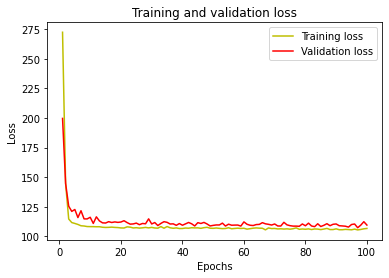


Predicted values are: 
 [[20.011732 ]
 [20.01438  ]
 [ 7.881962 ]
 [ 7.7971907]
 [20.114878 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 2ms/step - loss: 149.2142 - mean_absolute_error: 8.7365

Mean squared error from neural net: 
 149.21420288085938

Mean absolute error from neural net: 
 8.736455917358398

Predicted values are:
  [[0.00057001 0.00059043 0.0006188  ... 0.00058635 0.0005811  0.00057218]
 [0.00057011 0.00059051 0.00061877 ... 0.00058653 0.00058121 0.00057218]
 [0.000564   0.00058607 0.00061911 ... 0.00057811 0.00059142 0.00057677]
 [0.00056581 0.00058783 0.00061581 ... 0.00057893 0.00059327 0.00057732]
 [0.00057209 0.00059209 0.00061794 ... 0.00059035 0.00058376 0.0005721 ]]

Real values are: 
 29000    11.869
29001    16.458
29002     3.546
29003    13.095
29004    54.681
Name: kWhDelivered, dtype: float64
3/3 [========================

In [618]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Best 2:

Mean squared error from neural net: 
 149.21420288085938

Mean absolute error from neural net: 
 8.736455917358398

 Mean squared error using Random Forest:  267.29792056790865

Mean absolute error Using Random Forest:  14.550505776375797


# Predict one day with 1 year of data

In [619]:
train = df.loc[df['connectionTime_year'] == 2018]

In [620]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'] == 1]

In [621]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [622]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_411 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_412 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_413 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 52.5696 - mean_absolute_error: 5.2889 - val_loss: 85.2085 - val_mean_absolute_error: 7.0920
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.3607 - mean_absolute_error: 4.9358 - val_loss: 78.6744 - val_mean_absolute_error: 6.4580
Epoch 3/100
383/383 [=========================

383/383 [==============================] - 0s 1ms/step - loss: 43.6057 - mean_absolute_error: 4.9046 - val_loss: 79.0845 - val_mean_absolute_error: 6.5421
Epoch 46/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6498 - mean_absolute_error: 4.9096 - val_loss: 78.6144 - val_mean_absolute_error: 6.4846
Epoch 47/100
383/383 [==============================] - 0s 977us/step - loss: 43.6076 - mean_absolute_error: 4.9042 - val_loss: 81.8634 - val_mean_absolute_error: 6.8528
Epoch 48/100
383/383 [==============================] - 0s 1ms/step - loss: 43.6527 - mean_absolute_error: 4.9095 - val_loss: 81.0619 - val_mean_absolute_error: 6.7748
Epoch 49/100
383/383 [==============================] - 0s 990us/step - loss: 43.6401 - mean_absolute_error: 4.9060 - val_loss: 79.5592 - val_mean_absolute_error: 6.6092
Epoch 50/100
383/383 [==============================] - 0s 978us/step - loss: 43.6053 - mean_absolute_error: 4.9071 - val_loss: 82.9534 - val_mean_absolute_error: 6.9473

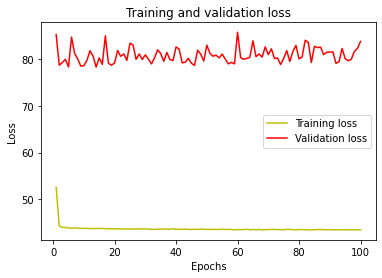


Predicted values are: 
 [[ 4.480546 ]
 [ 1.8087666]
 [ 4.9934397]
 [13.259205 ]
 [ 5.890233 ]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 196.8902 - mean_absolute_error: 8.8218

Mean squared error from neural net: 
 196.89022827148438

Mean absolute error from neural net: 
 8.821752548217773

Predicted values are:
  [[6.4781976e-05 6.4970627e-05 6.6046145e-05 ... 6.5578264e-05
  6.5622669e-05 6.5508772e-05]
 [6.4884189e-05 6.4678934e-05 6.6224660e-05 ... 6.5871129e-05
  6.5765977e-05 6.5060980e-05]
 [6.5374988e-05 6.5362205e-05 6.5461420e-05 ... 6.5404958e-05
  6.5450156e-05 6.5287117e-05]
 [6.5074913e-05 6.5061155e-05 6.5589527e-05 ... 6.5642103e-05
  6.5313070e-05 6.5586668e-05]
 [6.5378423e-05 6.5368564e-05 6.5443382e-05 ... 6.5399785e-05
  6.5439752e-05 6.5251435e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0

In [623]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 196.89022827148438

Mean absolute error from neural net: 
 8.821752548217773

 Mean squared error from Convolutional neural net:  247.55209350585938

Mean absolute error from Convolutional neural net:  9.516521453857422

# Predict 3 days with 1 year of data

In [624]:
train = df.loc[df['connectionTime_year'] == 2018]

In [625]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3])]

In [626]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [627]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_416 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_417 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_418 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 52.1858 - mean_absolute_error: 5.2809 - val_loss: 93.0142 - val_mean_absolute_error: 7.6467
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.4635 - mean_absolute_error: 4.9361 - val_loss: 87.8194 - val_mean_absolute_error: 7.2903
Epoch 3/100
383/383 [=========================

383/383 [==============================] - 0s 1ms/step - loss: 43.5157 - mean_absolute_error: 4.9072 - val_loss: 80.7888 - val_mean_absolute_error: 6.7266
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5048 - mean_absolute_error: 4.9050 - val_loss: 78.9020 - val_mean_absolute_error: 6.4925
Epoch 95/100
383/383 [==============================] - 0s 974us/step - loss: 43.5117 - mean_absolute_error: 4.9011 - val_loss: 83.0131 - val_mean_absolute_error: 6.9478
Epoch 96/100
383/383 [==============================] - 0s 974us/step - loss: 43.5138 - mean_absolute_error: 4.9045 - val_loss: 79.5049 - val_mean_absolute_error: 6.5841
Epoch 97/100
383/383 [==============================] - 0s 986us/step - loss: 43.5307 - mean_absolute_error: 4.9041 - val_loss: 85.7763 - val_mean_absolute_error: 7.1680
Epoch 98/100
383/383 [==============================] - 0s 981us/step - loss: 43.4924 - mean_absolute_error: 4.9078 - val_loss: 80.3808 - val_mean_absolute_error: 6.67

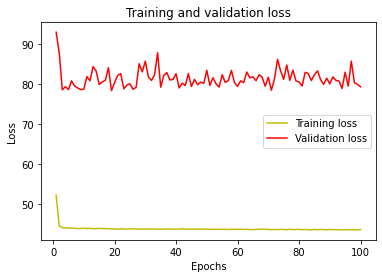


Predicted values are: 
 [[2.8764102]
 [1.9674088]
 [2.6499035]
 [3.302963 ]
 [2.6843169]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
3/3 [==============================] - 0s 1ms/step - loss: 194.0422 - mean_absolute_error: 10.1753

Mean squared error from neural net: 
 194.04220581054688

Mean absolute error from neural net: 
 10.17531681060791

Predicted values are:
  [[6.6158173e-05 6.4508196e-05 6.5109438e-05 ... 6.4635671e-05
  6.5862783e-05 6.6390581e-05]
 [6.6307592e-05 6.4311818e-05 6.4909429e-05 ... 6.4483611e-05
  6.6015346e-05 6.6654458e-05]
 [6.6079367e-05 6.4523512e-05 6.5089349e-05 ... 6.4684958e-05
  6.5824963e-05 6.6300228e-05]
 [6.5948188e-05 6.4610955e-05 6.5173095e-05 ... 6.4761589e-05
  6.5750981e-05 6.6143824e-05]
 [6.6065164e-05 6.4536944e-05 6.5099317e-05 ... 6.4695545e-05
  6.5815511e-05 6.6283690e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900


In [628]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 194.04220581054688

Mean absolute error from neural net: 
 10.17531681060791

 Mean squared error from Convolutional neural net:  285.1625061035156

Mean absolute error from Convolutional neural net:  11.897130966186523

# Predict 5 days with 1 year of data

In [629]:
train = df.loc[df['connectionTime_year'] == 2018]

In [630]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5])]

In [631]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [632]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_421 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_422 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_423 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 52.9021 - mean_absolute_error: 5.3034 - val_loss: 82.3733 - val_mean_absolute_error: 6.8706
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.3078 - mean_absolute_error: 4.9287 - val_loss: 82.3686 - val_mean_absolute_error: 6.8795
Epoch 3/100
383/383 [=========================

383/383 [==============================] - 0s 1ms/step - loss: 43.4728 - mean_absolute_error: 4.8993 - val_loss: 79.5104 - val_mean_absolute_error: 6.5976
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.4753 - mean_absolute_error: 4.8982 - val_loss: 82.3662 - val_mean_absolute_error: 6.8911
Epoch 95/100
383/383 [==============================] - 0s 963us/step - loss: 43.5051 - mean_absolute_error: 4.9034 - val_loss: 81.3157 - val_mean_absolute_error: 6.7984
Epoch 96/100
383/383 [==============================] - 0s 967us/step - loss: 43.5390 - mean_absolute_error: 4.9023 - val_loss: 81.6312 - val_mean_absolute_error: 6.8275
Epoch 97/100
383/383 [==============================] - 0s 959us/step - loss: 43.4683 - mean_absolute_error: 4.9008 - val_loss: 82.6279 - val_mean_absolute_error: 6.9194
Epoch 98/100
383/383 [==============================] - 0s 957us/step - loss: 43.4880 - mean_absolute_error: 4.9017 - val_loss: 82.1402 - val_mean_absolute_error: 6.86

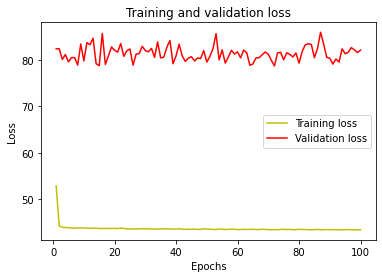


Predicted values are: 
 [[2.3319292]
 [1.94901  ]
 [2.3836136]
 [2.7490664]
 [2.4131262]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
4/4 [==============================] - 0s 1ms/step - loss: 204.6523 - mean_absolute_error: 10.5063

Mean squared error from neural net: 
 204.65234375

Mean absolute error from neural net: 
 10.506291389465332

Predicted values are:
  [[6.5677232e-05 6.5322121e-05 6.4996580e-05 ... 6.3584172e-05
  6.5948712e-05 6.6598310e-05]
 [6.5782260e-05 6.5232438e-05 6.5037355e-05 ... 6.3420288e-05
  6.5942884e-05 6.6805529e-05]
 [6.5702588e-05 6.5297485e-05 6.5121691e-05 ... 6.3789987e-05
  6.5861408e-05 6.6522400e-05]
 [6.5631604e-05 6.5378095e-05 6.5106862e-05 ... 6.3903877e-05
  6.5860193e-05 6.6400768e-05]
 [6.5699787e-05 6.5300526e-05 6.5130458e-05 ... 6.3811291e-05
  6.5853907e-05 6.6507950e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300

In [633]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 204.65234375

Mean absolute error from neural net: 
 10.506291389465332

Mean squared error from Convolutional neural net:  243.2482147216797

Mean absolute error from Convolutional neural net:  11.08861255645752

# Predict 1 week with 1 year of data

In [634]:
train = df.loc[df['connectionTime_year'] == 2018]

In [635]:
test = df.loc[df['connectionTime_year']==2019]
test = test.loc[test['connectionTime_month'] == 1]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [636]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [637]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_426 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_427 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_428 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
383/383 [==============================] - 1s 1ms/step - loss: 52.6555 - mean_absolute_error: 5.2531 - val_loss: 87.2586 - val_mean_absolute_error: 7.2389
Epoch 2/100
383/383 [==============================] - 0s 1ms/step - loss: 44.3352 - mean_absolute_error: 4.9333 - val_loss: 90.3634 - val_mean_absolute_error: 7.4611
Epoch 3/100
383/383 [=========================

383/383 [==============================] - 0s 1ms/step - loss: 43.5845 - mean_absolute_error: 4.9051 - val_loss: 83.3355 - val_mean_absolute_error: 6.9699
Epoch 94/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5469 - mean_absolute_error: 4.9033 - val_loss: 82.5591 - val_mean_absolute_error: 6.9033
Epoch 95/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5436 - mean_absolute_error: 4.9080 - val_loss: 82.1835 - val_mean_absolute_error: 6.8517
Epoch 96/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5634 - mean_absolute_error: 4.9026 - val_loss: 82.5728 - val_mean_absolute_error: 6.8970
Epoch 97/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5194 - mean_absolute_error: 4.9054 - val_loss: 80.8354 - val_mean_absolute_error: 6.7479
Epoch 98/100
383/383 [==============================] - 0s 1ms/step - loss: 43.5551 - mean_absolute_error: 4.9031 - val_loss: 82.8896 - val_mean_absolute_error: 6.9354
Epoch

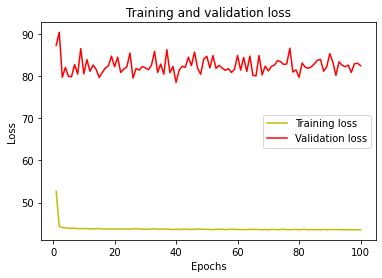


Predicted values are: 
 [[2.535555 ]
 [2.1819115]
 [2.458912 ]
 [2.6585455]
 [2.467434 ]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
15300    12.534
15301     0.883
Name: kWhDelivered, dtype: float64
6/6 [==============================] - 0s 1ms/step - loss: 181.9653 - mean_absolute_error: 9.9218

Mean squared error from neural net: 
 181.9652557373047

Mean absolute error from neural net: 
 9.92181396484375

Predicted values are:
  [[6.6300301e-05 6.4378379e-05 6.4560685e-05 ... 6.6776549e-05
  6.5189735e-05 6.5967200e-05]
 [6.6364446e-05 6.4360378e-05 6.4531676e-05 ... 6.6856584e-05
  6.5156120e-05 6.5974637e-05]
 [6.6227942e-05 6.4459709e-05 6.4610766e-05 ... 6.6669345e-05
  6.5183616e-05 6.5905493e-05]
 [6.6184810e-05 6.4472435e-05 6.4623462e-05 ... 6.6614914e-05
  6.5200555e-05 6.5893873e-05]
 [6.6218752e-05 6.4465217e-05 6.4615349e-05 ... 6.6658380e-05
  6.5184802e-05 6.5899869e-05]]

Real values are: 
 15297    43.114
15298     3.250
15299     0.900
153

In [638]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 181.9652557373047

Mean absolute error from neural net: 
 9.92181396484375

Mean squared error using Random Forest:  265.9261997741879

Mean absolute error Using Random Forest:  12.808809250546634


# Overall All Spaces

When ran on the 24 different DataFrames the following models occured:

Sequential Neural Network: 24 Times

Convolutional Neural Network: 4 Times

Linear Regression: 2 Times

Decision Tree: 2 Times

Random Forest: 16 Times

# Best result

2 Months 1 Day

Mean squared error from neural net: 
 83.28107452392578

Mean absolute error from neural net: 
 6.621450424194336

Mean squared error using Random Forest:  87.59891941785604

Mean absolute error Using Random Forest:  7.123862400000002

# Best 3 Day result

2 Months 3 Days

Mean squared error from neural net: 
 102.65827178955078

Mean absolute error from neural net: 
 7.4129815101623535

Mean squared error using Random Forest:  113.78877579587008

Mean absolute error Using Random Forest:  7.631643458292483

# Best 5 day result

2 Months 5 Days

Mean squared error from neural net: 
 117.1256103515625

Mean absolute error from neural net: 
 7.5160722732543945


Mean squared error using Random Forest:  100.1006992130904

Mean absolute error Using Random Forest:  7.348763723404256

# Best 1 Week Result

Mean squared error from neural net: 
 104.15814971923828

Mean absolute error from neural net: 
 6.946341037750244

 Mean squared error using Random Forest:  106.3441792968664

Mean absolute error Using Random Forest:  6.811379829758829


# Individual Spaces 

In [639]:
#create unique list of names
UniqueNames = df.spaceID.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df[:][df.spaceID == key]

In [640]:
UniqueNames

array(['CA-496', 'CA-319', 'CA-489', 'CA-327', 'CA-490', 'CA-303',
       'CA-499', 'CA-325', 'CA-491', 'CA-323', 'CA-317', 'CA-493',
       'CA-322', 'CA-311', 'CA-321', 'CA-309', 'CA-492', 'CA-315',
       'CA-497', 'CA-312', 'CA-501', 'CA-498', 'CA-313', 'CA-500',
       'CA-495', 'CA-314', 'CA-316', 'CA-502', 'CA-320', 'CA-326',
       'CA-503', 'CA-494', 'CA-324', 'CA-304', 'CA-308', 'CA-505',
       'CA-310', 'CA-305', 'CA-306', 'CA-318', 'CA-512', 'CA-510',
       'CA-307', 'CA-513', 'CA-507', 'CA-504', 'CA-509', 'CA-511',
       'CA-212', 'CA-508', 'CA-506', 'CA-149', 'CA-213', 'CA-148',
       '11900388'], dtype=object)

# Space 324

# 1 month of training data to predict the demand of 1 space for 1 day

In [641]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [642]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [643]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [644]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_431 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_432 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_433 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 389ms/step - loss: 268.2174 - mean_absolute_error: 13.0040 - val_loss: 59.9549 - val_mean_absolute_error: 6.9825
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 265.6729 - mean_absolute_error: 12.9196 - val_loss: 58.2821 - val_mean_absolute_error: 6.8544
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 25ms/step - loss: 118.9953 - mean_absolute_error: 7.1359 - val_loss: 36.5042 - val_mean_absolute_error: 5.3754
Epoch 47/100
1/1 [==============================] - 0s 20ms/step - loss: 115.5532 - mean_absolute_error: 6.9845 - val_loss: 40.6166 - val_mean_absolute_error: 5.6451
Epoch 48/100
1/1 [==============================] - 0s 23ms/step - loss: 112.2660 - mean_absolute_error: 6.8309 - val_loss: 45.1586 - val_mean_absolute_error: 5.9179
Epoch 49/100
1/1 [==============================] - 0s 23ms/step - loss: 109.1461 - mean_absolute_error: 6.6753 - val_loss: 50.1397 - val_mean_absolute_error: 6.1941
Epoch 50/100
1/1 [==============================] - 0s 55ms/step - loss: 106.2084 - mean_absolute_error: 6.5182 - val_loss: 55.5248 - val_mean_absolute_error: 6.4706
Epoch 51/100
1/1 [==============================] - 0s 24ms/step - loss: 103.4647 - mean_absolute_error: 6.3599 - val_loss: 61.3034 - val_mean_absolute_error: 6.7472
Epoc

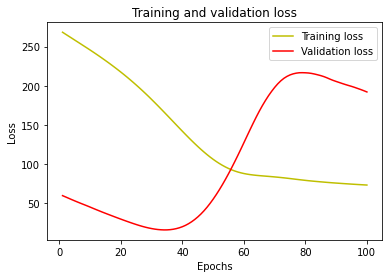


Predicted values are: 
 [[4.456425]]

Real values are: 
 16309    8.727
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 18.2378 - mean_absolute_error: 4.2706

Mean squared error from neural net: 
 18.237812042236328

Mean absolute error from neural net: 
 4.270575046539307

Predicted values are:
  [[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
  0.05 0.05 0.05 0.05 0.05 0.05]]

Real values are: 
 16309    8.727
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 166ms/step - loss: 75.2903 - mean_absolute_error: 8.6770

Mean squared error from Convolutional neural net:  75.29032897949219

Mean absolute error from Convolutional neural net:  8.677000045776367

Mean squared error from linear regression:  10.540411559717693

Mean absolute error from linear regression:  3.2465999999565227

Mean squared error using decision tree:  29.278921000000004

Mean absolute error using decision tree:  5.41

In [645]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 18.237812042236328

Mean absolute error from neural net: 
 4.270575046539307

 Mean squared error from linear regression:  10.540411559717693

Mean absolute error from linear regression:  3.2465999999565227

# 1 Month to predict 1 week

In [646]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [647]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [648]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [649]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_437 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_438 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 354ms/step - loss: 147.1815 - mean_absolute_error: 10.3013 - val_loss: 109.1526 - val_mean_absolute_error: 7.3150
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 145.1017 - mean_absolute_error: 10.1989 - val_loss: 107.2988 - val_mean_absolute_error: 7.1874
Epoch 3/100
1/1 [============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 59.6839 - mean_absolute_error: 6.1227 - val_loss: 63.2753 - val_mean_absolute_error: 6.8791
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 58.1598 - mean_absolute_error: 6.1058 - val_loss: 65.8290 - val_mean_absolute_error: 7.1633
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 56.7128 - mean_absolute_error: 6.0865 - val_loss: 68.8328 - val_mean_absolute_error: 7.4806
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 55.3382 - mean_absolute_error: 6.0647 - val_loss: 72.3150 - val_mean_absolute_error: 7.8053
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 54.0307 - mean_absolute_error: 6.0402 - val_loss: 76.3007 - val_mean_absolute_error: 8.1372
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 52.7848 - mean_absolute_error: 6.0131 - val_loss: 80.8000 - val_mean_absolute_error: 8.4750
Epoch 52/1

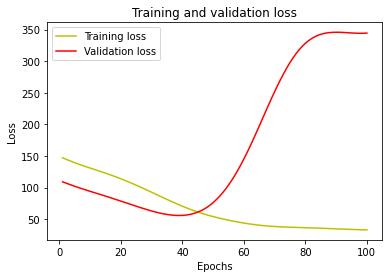


Predicted values are: 
 [[7.9926953]
 [7.8317866]
 [8.893291 ]
 [8.151758 ]
 [7.4899745]]

Real values are: 
 3903    13.811
3913     8.320
3937    31.814
3961     8.689
4032    10.649
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 179.0926 - mean_absolute_error: 10.2966

Mean squared error from neural net: 
 179.09262084960938

Mean absolute error from neural net: 
 10.296606063842773

Predicted values are:
  [[0.02891607 0.02653615 0.0276183  0.03529562 0.03065035 0.02725578
  0.03082158 0.02792856 0.029804   0.02683563 0.03184875 0.02825977
  0.02701528 0.03075149 0.03211131 0.03294689 0.03439056 0.02713414
  0.03796481 0.03015439 0.02862007 0.0274106  0.03263851 0.03030759
  0.03169857 0.02686888 0.02838921 0.02990099 0.03641359 0.03309992
  0.03502968 0.02667152 0.02871154]
 [0.02903332 0.02666808 0.02778395 0.03511168 0.03055206 0.02727098
  0.03079631 0.02801396 0.02984226 0.02692112 0.0317196  0.02823067
  0.02715616 0.03071085 0

In [650]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 179.09262084960938

Mean absolute error from neural net: 
 10.296606063842773

 Mean squared error using Random Forest:  124.18021324321256

Mean absolute error Using Random Forest:  7.787178750000004


# 6 Month training 1 week predicition

In [651]:
train = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [652]:
test = DataFrameDict['CA-324'].loc[DataFrameDict['CA-324']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [653]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [654]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_441 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_442 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_443 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 34ms/step - loss: 179.5377 - mean_absolute_error: 10.3254 - val_loss: 97.0182 - val_mean_absolute_error: 7.9898
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 172.5280 - mean_absolute_error: 9.9930 - val_loss: 88.6024 - val_mean_absolute_error: 7.4965
Epoch 3/100
4/4 [==============================] -

Epoch 46/100
4/4 [==============================] - 0s 13ms/step - loss: 65.2746 - mean_absolute_error: 5.9293 - val_loss: 79.1328 - val_mean_absolute_error: 7.6475
Epoch 47/100
4/4 [==============================] - 0s 7ms/step - loss: 65.1533 - mean_absolute_error: 5.9301 - val_loss: 80.3021 - val_mean_absolute_error: 7.7068
Epoch 48/100
4/4 [==============================] - 0s 15ms/step - loss: 65.1141 - mean_absolute_error: 5.9420 - val_loss: 81.6844 - val_mean_absolute_error: 7.7705
Epoch 49/100
4/4 [==============================] - 0s 8ms/step - loss: 64.9931 - mean_absolute_error: 5.9603 - val_loss: 82.9905 - val_mean_absolute_error: 7.8289
Epoch 50/100
4/4 [==============================] - 0s 6ms/step - loss: 65.1619 - mean_absolute_error: 5.9968 - val_loss: 85.3346 - val_mean_absolute_error: 7.9463
Epoch 51/100
4/4 [==============================] - 0s 7ms/step - loss: 65.1969 - mean_absolute_error: 6.0035 - val_loss: 85.0108 - val_mean_absolute_error: 7.9263
Epoch 52/100
4

Epoch 96/100
4/4 [==============================] - 0s 6ms/step - loss: 63.2731 - mean_absolute_error: 5.7405 - val_loss: 65.2540 - val_mean_absolute_error: 6.8659
Epoch 97/100
4/4 [==============================] - 0s 7ms/step - loss: 63.3191 - mean_absolute_error: 5.7689 - val_loss: 67.0417 - val_mean_absolute_error: 6.9481
Epoch 98/100
4/4 [==============================] - 0s 6ms/step - loss: 63.0829 - mean_absolute_error: 5.7921 - val_loss: 66.4009 - val_mean_absolute_error: 6.9129
Epoch 99/100
4/4 [==============================] - 0s 6ms/step - loss: 63.0672 - mean_absolute_error: 5.7922 - val_loss: 66.8522 - val_mean_absolute_error: 6.9323
Epoch 100/100
4/4 [==============================] - 0s 6ms/step - loss: 63.0112 - mean_absolute_error: 5.7963 - val_loss: 66.9779 - val_mean_absolute_error: 6.9354


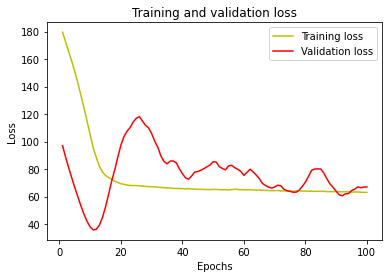


Predicted values are: 
 [[10.363131]
 [13.639283]]

Real values are: 
 21113    2.18
21134    3.22
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 87.7625 - mean_absolute_error: 9.3012

Mean squared error from neural net: 
 87.76254272460938

Mean absolute error from neural net: 
 9.301206588745117

Predicted values are:
  [[0.00833015 0.00827811 0.00816154 0.00758529 0.00709249 0.00797028
  0.00821809 0.0086401  0.00841213 0.00799171 0.00821886 0.00817746
  0.00775367 0.00768668 0.00837068 0.00732271 0.00845739 0.0076726
  0.00784662 0.00794717 0.00718424 0.00754851 0.00751725 0.00802171
  0.00779115 0.0076437  0.00706192 0.00759483 0.00841195 0.00868524
  0.00818589 0.00751773 0.00747001 0.00766787 0.00750548 0.00776013
  0.00818204 0.0072551  0.00793644 0.00715661 0.00783061 0.00729315
  0.00744464 0.00798617 0.00853521 0.00759831 0.00764903 0.00741449
  0.00812384 0.00776815 0.00818516 0.00785329 0.00795141 0.00751749
  0.00817744 0.0

In [655]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 87.76254272460938

Mean absolute error from neural net: 
 9.301206588745117

 Mean squared error from Convolutional neural net:  7.518273830413818

Mean absolute error from Convolutional neural net:  2.692187547683716

# Space 322

# 1 month of training data to predict the demand of 1 space for 1 day

In [656]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [657]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [658]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [659]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_446 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_447 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_448 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 365ms/step - loss: 125.7599 - mean_absolute_error: 8.0160 - val_loss: 67.0913 - val_mean_absolute_error: 8.0802
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 124.5674 - mean_absolute_error: 7.9319 - val_loss: 65.2132 - val_mean_absolute_error: 7.9632
Epoch 3/100
1/1 [==============================] 

1/1 [==============================] - 0s 17ms/step - loss: 79.0307 - mean_absolute_error: 5.9713 - val_loss: 6.2160 - val_mean_absolute_error: 2.0898
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 78.3604 - mean_absolute_error: 5.9602 - val_loss: 6.9534 - val_mean_absolute_error: 2.2930
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 77.7223 - mean_absolute_error: 5.9478 - val_loss: 7.9852 - val_mean_absolute_error: 2.5027
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 77.1088 - mean_absolute_error: 5.9334 - val_loss: 9.2969 - val_mean_absolute_error: 2.7147
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 76.5084 - mean_absolute_error: 5.9164 - val_loss: 10.9026 - val_mean_absolute_error: 2.9296
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 75.9210 - mean_absolute_error: 5.8967 - val_loss: 12.8048 - val_mean_absolute_error: 3.1458
Epoch 52/100
1/1 [=========

Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 63.0084 - mean_absolute_error: 5.2932 - val_loss: 62.4150 - val_mean_absolute_error: 7.8063
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 62.7716 - mean_absolute_error: 5.2880 - val_loss: 62.2945 - val_mean_absolute_error: 7.8076
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 62.5362 - mean_absolute_error: 5.2816 - val_loss: 62.2963 - val_mean_absolute_error: 7.8161
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 62.3069 - mean_absolute_error: 5.2745 - val_loss: 62.4326 - val_mean_absolute_error: 7.8322
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 62.0813 - mean_absolute_error: 5.2662 - val_loss: 62.7270 - val_mean_absolute_error: 7.8577


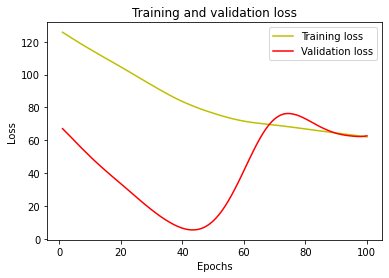


Predicted values are: 
 [[4.045038]]

Real values are: 
 16301    12.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 78.1626 - mean_absolute_error: 8.8410

Mean squared error from neural net: 
 78.16259765625

Mean absolute error from neural net: 
 8.840961456298828

Predicted values are:
  [[0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
  0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
  0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]]

Real values are: 
 16301    12.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 437ms/step - loss: 164.6203 - mean_absolute_error: 12.8304

Mean squared error from Convolutional neural net:  164.62030029296875

Mean absolute error from Convolutional neural net:  12.8304443359375

Mean squared error from linear regression:  23.0043599508838

Mean absolute error from linear regression:  4.796286058074914

Mean squar

In [660]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  23.0043599508838

Mean absolute error from linear regression:  4.796286058074914

Mean squared error using decision tree:  17.32224399999999

Mean absolute error using decision tree:  4.161999999999999

# 1 Month to predict 1 week

In [661]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [662]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [663]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [664]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_452 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_453 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 376ms/step - loss: 149.2716 - mean_absolute_error: 9.0625 - val_loss: 165.2635 - val_mean_absolute_error: 10.6560
Epoch 2/100
1/1 [==============================] - 0s 23ms/step - loss: 147.6932 - mean_absolute_error: 8.9720 - val_loss: 162.5558 - val_mean_absolute_error: 10.5299
Epoch 3/100
1/1 [============================

Epoch 46/100
1/1 [==============================] - 0s 20ms/step - loss: 87.7284 - mean_absolute_error: 6.8110 - val_loss: 57.9518 - val_mean_absolute_error: 4.3086
Epoch 47/100
1/1 [==============================] - 0s 19ms/step - loss: 86.5753 - mean_absolute_error: 6.7811 - val_loss: 55.5911 - val_mean_absolute_error: 4.3058
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 85.4573 - mean_absolute_error: 6.7558 - val_loss: 53.3614 - val_mean_absolute_error: 4.3537
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 84.3723 - mean_absolute_error: 6.7290 - val_loss: 51.2789 - val_mean_absolute_error: 4.4022
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 83.3158 - mean_absolute_error: 6.7004 - val_loss: 49.3590 - val_mean_absolute_error: 4.5170
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 82.2805 - mean_absolute_error: 6.6698 - val_loss: 47.6223 - val_mean_absolute_error: 4.6682
Epoch 52/1

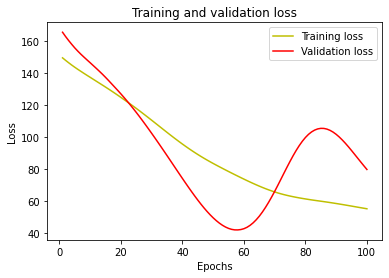


Predicted values are: 
 [[17.095932 ]
 [ 7.4284368]
 [ 5.1749845]
 [ 4.143972 ]
 [ 4.7787175]]

Real values are: 
 3905     2.683
3948     4.958
4027    20.483
4056    22.438
4103     5.126
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 115.9470 - mean_absolute_error: 8.4773

Mean squared error from neural net: 
 115.94696044921875

Mean absolute error from neural net: 
 8.477322578430176

Predicted values are:
  [[0.02389101 0.03534151 0.02522075 0.02846814 0.02868933 0.02142718
  0.01278117 0.03236938 0.02522158 0.02136008 0.03651943 0.0286295
  0.02481232 0.02101453 0.02469424 0.02381538 0.02723191 0.02605757
  0.02576067 0.02924495 0.02683314 0.01957969 0.02841275 0.03366009
  0.03009353 0.02946893 0.04283121 0.02333821 0.02444695 0.02586067
  0.02294756 0.03481895 0.0250026  0.02752338 0.02869608 0.02782471
  0.02611087]
 [0.02326935 0.03366624 0.02447996 0.02909664 0.02808657 0.0241166
  0.01717812 0.03132552 0.02427264 0.02363081 

In [665]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 115.94696044921875

Mean absolute error from neural net: 
 8.477322578430176

 Mean squared error from Convolutional neural net:  125.59464263916016

Mean absolute error from Convolutional neural net:  8.888972282409668


# 6 Month training 1 week predicition

In [666]:
train = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [667]:
test = DataFrameDict['CA-322'].loc[DataFrameDict['CA-322']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [668]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [669]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_456 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_457 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_458 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 35ms/step - loss: 139.5958 - mean_absolute_error: 8.1855 - val_loss: 182.6501 - val_mean_absolute_error: 7.9137
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 134.2797 - mean_absolute_error: 7.8512 - val_loss: 176.5937 - val_mean_absolute_error: 7.6108
Epoch 3/100
4/4 [==============================] 

Epoch 46/100
4/4 [==============================] - 0s 7ms/step - loss: 67.0633 - mean_absolute_error: 5.8459 - val_loss: 130.8276 - val_mean_absolute_error: 6.9298
Epoch 47/100
4/4 [==============================] - 0s 6ms/step - loss: 66.8024 - mean_absolute_error: 5.8683 - val_loss: 131.1537 - val_mean_absolute_error: 6.9263
Epoch 48/100
4/4 [==============================] - 0s 7ms/step - loss: 66.9685 - mean_absolute_error: 5.9576 - val_loss: 131.7746 - val_mean_absolute_error: 6.9231
Epoch 49/100
4/4 [==============================] - 0s 6ms/step - loss: 67.2552 - mean_absolute_error: 5.9985 - val_loss: 134.1826 - val_mean_absolute_error: 6.9366
Epoch 50/100
4/4 [==============================] - 0s 6ms/step - loss: 67.1507 - mean_absolute_error: 5.9925 - val_loss: 135.3410 - val_mean_absolute_error: 6.9570
Epoch 51/100
4/4 [==============================] - 0s 7ms/step - loss: 66.8890 - mean_absolute_error: 5.9732 - val_loss: 136.2928 - val_mean_absolute_error: 6.9784
Epoch 52/1

Epoch 96/100
4/4 [==============================] - 0s 7ms/step - loss: 62.5992 - mean_absolute_error: 5.6775 - val_loss: 165.9237 - val_mean_absolute_error: 8.5403
Epoch 97/100
4/4 [==============================] - 0s 6ms/step - loss: 62.6891 - mean_absolute_error: 5.7195 - val_loss: 165.8070 - val_mean_absolute_error: 8.5557
Epoch 98/100
4/4 [==============================] - 0s 6ms/step - loss: 62.4728 - mean_absolute_error: 5.6955 - val_loss: 170.1216 - val_mean_absolute_error: 8.7620
Epoch 99/100
4/4 [==============================] - 0s 6ms/step - loss: 62.4182 - mean_absolute_error: 5.6659 - val_loss: 173.2324 - val_mean_absolute_error: 8.9080
Epoch 100/100
4/4 [==============================] - 0s 14ms/step - loss: 62.4000 - mean_absolute_error: 5.6496 - val_loss: 173.6837 - val_mean_absolute_error: 8.9354


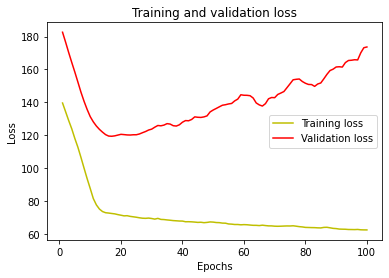


Predicted values are: 
 [[ 9.614888]
 [ 9.493054]
 [ 9.887088]
 [10.175451]
 [10.504333]]

Real values are: 
 21112     0.839
21115    11.867
21143     1.042
21144     0.950
21146     1.024
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 67.1746 - mean_absolute_error: 7.7401

Mean squared error from neural net: 
 67.17460632324219

Mean absolute error from neural net: 
 7.740140438079834

Predicted values are:
  [[0.00726987 0.00774498 0.00784322 0.00698756 0.0079389  0.00815837
  0.00758068 0.0079241  0.00799461 0.00716712 0.00805833 0.00719776
  0.00723828 0.00755757 0.00751528 0.00770947 0.00758664 0.00684656
  0.00785612 0.00781743 0.00759402 0.00869027 0.0071859  0.00810842
  0.00807668 0.00772574 0.00835558 0.00811491 0.00840496 0.00766107
  0.0082659  0.00797355 0.00846089 0.00845494 0.00820244 0.00713828
  0.00773433 0.0073118  0.00840041 0.00844455 0.00886014 0.00778736
  0.00844574 0.00775754 0.00759802 0.00806706 0.00748542 0.0

In [670]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 67.17460632324219

Mean absolute error from neural net: 
 7.740140438079834

 Mean squared error from Convolutional neural net:  28.86421775817871

Mean absolute error from Convolutional neural net:  3.136587381362915

# Space 497

# 1 month of training data to predict the demand of 1 space for 1 day

In [671]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [672]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [673]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [674]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_461 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_462 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_463 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 365ms/step - loss: 385.9324 - mean_absolute_error: 15.5631 - val_loss: 424.7640 - val_mean_absolute_error: 15.4258
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 383.1499 - mean_absolute_error: 15.4750 - val_loss: 420.4934 - val_mean_absolute_error: 15.2890
Epoch 3/100
1/1 [==========================

Epoch 94/100
1/1 [==============================] - 0s 18ms/step - loss: 106.1514 - mean_absolute_error: 9.0098 - val_loss: 566.8603 - val_mean_absolute_error: 20.8931
Epoch 95/100
1/1 [==============================] - 0s 18ms/step - loss: 104.8898 - mean_absolute_error: 8.9410 - val_loss: 574.1890 - val_mean_absolute_error: 21.1147
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 103.6543 - mean_absolute_error: 8.8714 - val_loss: 581.1347 - val_mean_absolute_error: 21.3244
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 102.4462 - mean_absolute_error: 8.8009 - val_loss: 587.7816 - val_mean_absolute_error: 21.5242
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 101.2660 - mean_absolute_error: 8.7295 - val_loss: 594.0914 - val_mean_absolute_error: 21.7134
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 100.1167 - mean_absolute_error: 8.6573 - val_loss: 600.0643 - val_mean_absolute_error: 

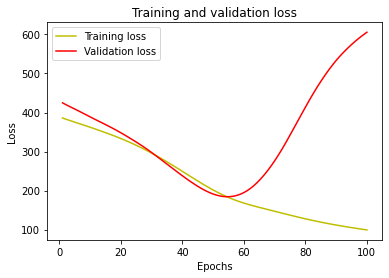


Predicted values are: 
 [[10.551219]
 [16.284643]]

Real values are: 
 16295    13.511
16318     8.647
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 33.5469 - mean_absolute_error: 5.2987

Mean squared error from neural net: 
 33.54694366455078

Mean absolute error from neural net: 
 5.298711776733398

Predicted values are:
  [[0.0508144  0.05173162 0.04896618 0.04726521 0.04912811 0.04861227
  0.04891086 0.05180018 0.04966564 0.04799116 0.04759143 0.05273937
  0.05569636 0.05132495 0.04586117 0.04831433 0.05281078 0.05042312
  0.05036387 0.04998904]
 [0.04838116 0.05317981 0.04723146 0.04496607 0.04985952 0.05039197
  0.0467141  0.05063675 0.04661733 0.04922445 0.0518705  0.05038389
  0.05644387 0.052517   0.0483349  0.04728239 0.05374916 0.04968723
  0.05064585 0.05188264]]

Real values are: 
 16295    13.511
16318     8.647
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 164ms/step - loss: 127.5535 - mean_

In [675]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 33.54694366455078

Mean absolute error from neural net: 
 5.298711776733398

Mean squared error using Random Forest:  8.430320786899973

Mean absolute error Using Random Forest:  2.713869999999991

# 1 Month to predict 1 week

In [676]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [677]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [678]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [679]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_466 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_467 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_468 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 365ms/step - loss: 127.0912 - mean_absolute_error: 9.6684 - val_loss: 50.0268 - val_mean_absolute_error: 5.4318
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 125.8994 - mean_absolute_error: 9.5994 - val_loss: 48.6894 - val_mean_absolute_error: 5.3037
Epoch 3/100
1/1 [==============================] 

Epoch 46/100
1/1 [==============================] - 0s 17ms/step - loss: 64.9861 - mean_absolute_error: 6.2288 - val_loss: 38.6281 - val_mean_absolute_error: 5.5756
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 63.6658 - mean_absolute_error: 6.1698 - val_loss: 42.2969 - val_mean_absolute_error: 5.8782
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 62.3807 - mean_absolute_error: 6.1083 - val_loss: 46.4211 - val_mean_absolute_error: 6.1884
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 61.1361 - mean_absolute_error: 6.0450 - val_loss: 51.0200 - val_mean_absolute_error: 6.5061
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 59.9237 - mean_absolute_error: 5.9792 - val_loss: 56.1182 - val_mean_absolute_error: 6.8308
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 58.7410 - mean_absolute_error: 5.9110 - val_loss: 61.7272 - val_mean_absolute_error: 7.1617
Epoch 52/1

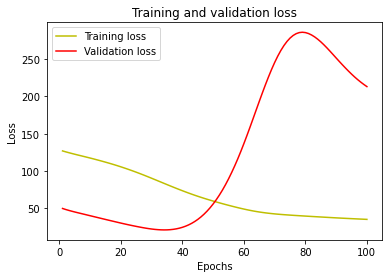


Predicted values are: 
 [[13.298659]
 [ 5.721962]
 [12.374299]]

Real values are: 
 4042     6.641
4118    36.395
4184     9.835
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 330.5359 - mean_absolute_error: 13.2900

Mean squared error from neural net: 
 330.5359191894531

Mean absolute error from neural net: 
 13.289998054504395

Predicted values are:
  [[0.03417797 0.03095733 0.02988605 0.03207055 0.0313791  0.02437615
  0.0316843  0.02964945 0.0305919  0.02420298 0.02832551 0.03039022
  0.03372525 0.031257   0.03408972 0.02870025 0.03069788 0.0368588
  0.02666452 0.03304542 0.03113498 0.02834791 0.03211073 0.02902393
  0.03179114 0.02543696 0.03057253 0.03129677 0.02931849 0.0321762
  0.02901981 0.02818401 0.02885626]
 [0.03023042 0.03037094 0.03053367 0.03113907 0.03133047 0.02917992
  0.03016177 0.03028196 0.03090992 0.02970168 0.02946969 0.02947178
  0.03082198 0.03049507 0.03034898 0.02996637 0.03025925 0.0312918
  0.02993794 0.03

In [680]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  181.30599388416144

Mean absolute error from linear regression:  8.823666666480948

Mean squared error using Random Forest:  194.13588130859986

Mean absolute error Using Random Forest:  10.142719999999999

# 6 Month training 1 week predicition

In [681]:
train = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [682]:
test = DataFrameDict['CA-497'].loc[DataFrameDict['CA-497']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [683]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [684]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_471 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_472 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_473 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 64ms/step - loss: 315.8752 - mean_absolute_error: 13.9534 - val_loss: 79.0609 - val_mean_absolute_error: 7.2318
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 307.8684 - mean_absolute_error: 13.6924 - val_loss: 74.2736 - val_mean_absolute_error: 7.0274
Epoch 3/100
3/3 [==============================]

Epoch 46/100
3/3 [==============================] - 0s 10ms/step - loss: 104.4053 - mean_absolute_error: 7.5588 - val_loss: 52.3306 - val_mean_absolute_error: 5.6871
Epoch 47/100
3/3 [==============================] - 0s 10ms/step - loss: 104.0252 - mean_absolute_error: 7.5688 - val_loss: 51.5779 - val_mean_absolute_error: 5.6469
Epoch 48/100
3/3 [==============================] - 0s 9ms/step - loss: 103.8398 - mean_absolute_error: 7.5833 - val_loss: 50.4181 - val_mean_absolute_error: 5.5890
Epoch 49/100
3/3 [==============================] - 0s 9ms/step - loss: 103.9816 - mean_absolute_error: 7.6087 - val_loss: 49.3903 - val_mean_absolute_error: 5.5365
Epoch 50/100
3/3 [==============================] - 0s 11ms/step - loss: 103.8661 - mean_absolute_error: 7.6165 - val_loss: 48.5452 - val_mean_absolute_error: 5.4916
Epoch 51/100
3/3 [==============================] - 0s 9ms/step - loss: 103.5798 - mean_absolute_error: 7.6041 - val_loss: 48.0250 - val_mean_absolute_error: 5.4612
Epoch 5

Epoch 96/100
3/3 [==============================] - 0s 9ms/step - loss: 98.3897 - mean_absolute_error: 7.3651 - val_loss: 33.1313 - val_mean_absolute_error: 4.6873
Epoch 97/100
3/3 [==============================] - 0s 10ms/step - loss: 98.2643 - mean_absolute_error: 7.3487 - val_loss: 32.7057 - val_mean_absolute_error: 4.6842
Epoch 98/100
3/3 [==============================] - 0s 10ms/step - loss: 98.3451 - mean_absolute_error: 7.3274 - val_loss: 32.0414 - val_mean_absolute_error: 4.6687
Epoch 99/100
3/3 [==============================] - 0s 9ms/step - loss: 98.3266 - mean_absolute_error: 7.2971 - val_loss: 31.7015 - val_mean_absolute_error: 4.6541
Epoch 100/100
3/3 [==============================] - 0s 9ms/step - loss: 98.2300 - mean_absolute_error: 7.2880 - val_loss: 31.4482 - val_mean_absolute_error: 4.6365


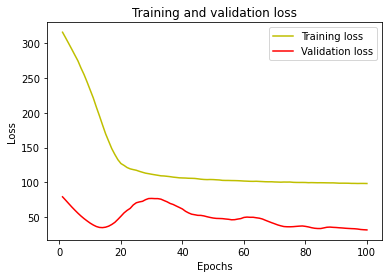


Predicted values are: 
 [[13.267096 ]
 [10.8694725]]

Real values are: 
 21109    40.817
21139    16.716
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 396.5895 - mean_absolute_error: 16.6982

Mean squared error from neural net: 
 396.58953857421875

Mean absolute error from neural net: 
 16.69821548461914

Predicted values are:
  [[0.0104892  0.01149198 0.01068408 0.01140067 0.01095919 0.01134828
  0.01076531 0.0109504  0.01085133 0.01097612 0.01031588 0.01030701
  0.01141725 0.01205622 0.01146666 0.01175317 0.01201426 0.01157023
  0.01195683 0.01106072 0.01124562 0.01068807 0.01120787 0.01116305
  0.01188925 0.01316882 0.01086456 0.01241372 0.01017338 0.01036952
  0.01066446 0.01189245 0.01157472 0.01047979 0.01145939 0.01202753
  0.01192648 0.01073311 0.01175033 0.01154164 0.01045147 0.01083876
  0.01123526 0.01109332 0.0105606  0.01046799 0.01244583 0.01092139
  0.01077885 0.01146676 0.01149447 0.01094977 0.01235374 0.00989221
  0.01

In [685]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  386.35109000000006

Mean absolute error using decision tree:  14.173

Mean squared error using Random Forest:  318.0916757008996

Mean absolute error Using Random Forest:  15.14646999999999


# Space 303

# 1 month of training data to predict the demand of 1 space for 1 day

In [686]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [687]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [688]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [689]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_476 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_477 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_478 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 103ms/step - loss: 202.0847 - mean_absolute_error: 8.2322 - val_loss: 281.9506 - val_mean_absolute_error: 10.3422
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 200.1174 - mean_absolute_error: 8.0892 - val_loss: 277.0564 - val_mean_absolute_error: 10.1128
Epoch 3/100
2/2 [============================

Epoch 94/100
2/2 [==============================] - 0s 18ms/step - loss: 126.5591 - mean_absolute_error: 6.8974 - val_loss: 197.9188 - val_mean_absolute_error: 11.5713
Epoch 95/100
2/2 [==============================] - 0s 18ms/step - loss: 126.4764 - mean_absolute_error: 6.8875 - val_loss: 196.9382 - val_mean_absolute_error: 11.5208
Epoch 96/100
2/2 [==============================] - 0s 16ms/step - loss: 126.4805 - mean_absolute_error: 6.8788 - val_loss: 194.9927 - val_mean_absolute_error: 11.4141
Epoch 97/100
2/2 [==============================] - 0s 17ms/step - loss: 126.4788 - mean_absolute_error: 6.8575 - val_loss: 193.8162 - val_mean_absolute_error: 11.3509
Epoch 98/100
2/2 [==============================] - 0s 18ms/step - loss: 126.3046 - mean_absolute_error: 6.8428 - val_loss: 193.3595 - val_mean_absolute_error: 11.3276
Epoch 99/100
2/2 [==============================] - 0s 17ms/step - loss: 126.3197 - mean_absolute_error: 6.8493 - val_loss: 193.1814 - val_mean_absolute_error: 

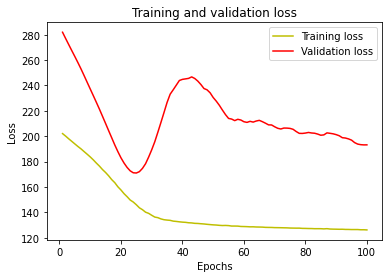


Predicted values are: 
 [[ 5.4224925]
 [ 5.8658853]
 [10.525426 ]]

Real values are: 
 16285    15.582
16294     4.910
16325    16.395
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 46.1937 - mean_absolute_error: 5.6617

Mean squared error from neural net: 
 46.19374465942383

Mean absolute error from neural net: 
 5.661655902862549

Predicted values are:
  [[0.01305554 0.01445671 0.01534948 0.01415366 0.01315684 0.0128784
  0.01338256 0.01630239 0.01457941 0.01448694 0.01548509 0.01501424
  0.01515799 0.01596727 0.01342889 0.01357258 0.01320039 0.01396747
  0.01386234 0.01384445 0.01310051 0.01555115 0.01275536 0.01433494
  0.01464406 0.0141057  0.01289722 0.01364778 0.01668854 0.01242491
  0.0148199  0.0127366  0.01366187 0.0137658  0.0140355  0.0163736
  0.0139864  0.01446545 0.01350604 0.01511035 0.01461042 0.01526712
  0.01335529 0.01458229 0.01344806 0.01180493 0.01361879 0.01247259
  0.01375482 0.01328138 0.01399584 0.01428219 0.0

In [690]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 46.19374465942383

Mean absolute error from neural net: 
 5.661655902862549

 Mean squared error using Random Forest:  97.00961524166672

Mean absolute error Using Random Forest:  9.839360000000003

# 1 Month to predict 1 week

In [691]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [692]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [693]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [694]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_481 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_482 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_483 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 104ms/step - loss: 165.8793 - mean_absolute_error: 10.4694 - val_loss: 163.2001 - val_mean_absolute_error: 8.3722
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 161.8984 - mean_absolute_error: 10.2783 - val_loss: 158.7336 - val_mean_absolute_error: 8.1060
Epoch 3/100
2/2 [============================

Epoch 46/100
2/2 [==============================] - 0s 18ms/step - loss: 60.9606 - mean_absolute_error: 5.2280 - val_loss: 118.9412 - val_mean_absolute_error: 8.9606
Epoch 47/100
2/2 [==============================] - 0s 18ms/step - loss: 60.5027 - mean_absolute_error: 5.2122 - val_loss: 117.5633 - val_mean_absolute_error: 8.8581
Epoch 48/100
2/2 [==============================] - 0s 17ms/step - loss: 60.3430 - mean_absolute_error: 5.2052 - val_loss: 116.3378 - val_mean_absolute_error: 8.7646
Epoch 49/100
2/2 [==============================] - 0s 17ms/step - loss: 60.1767 - mean_absolute_error: 5.2023 - val_loss: 115.4058 - val_mean_absolute_error: 8.6920
Epoch 50/100
2/2 [==============================] - 0s 17ms/step - loss: 60.0524 - mean_absolute_error: 5.2109 - val_loss: 114.6954 - val_mean_absolute_error: 8.6343
Epoch 51/100
2/2 [==============================] - 0s 17ms/step - loss: 59.7188 - mean_absolute_error: 5.2029 - val_loss: 114.0954 - val_mean_absolute_error: 8.5867
Epoc

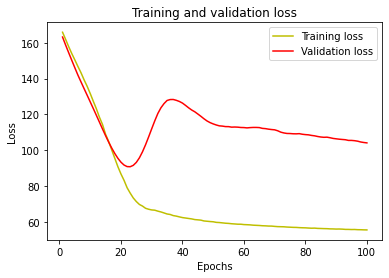


Predicted values are: 
 [[12.256223]
 [12.02161 ]
 [11.841492]
 [11.639396]
 [15.370368]]

Real values are: 
 3892     2.300
3904     4.083
3907    10.381
3919     5.213
3932     5.924
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 46.8775 - mean_absolute_error: 5.9406

Mean squared error from neural net: 
 46.877540588378906

Mean absolute error from neural net: 
 5.940613269805908

Predicted values are:
  [[0.01516611 0.01410472 0.01592616 0.01604026 0.01509325 0.01329829
  0.01364883 0.01244684 0.01352817 0.01600744 0.01454439 0.01439391
  0.01370179 0.01309995 0.01348454 0.01658835 0.01555437 0.01427597
  0.01437845 0.01397135 0.01377621 0.01417924 0.01277945 0.01331269
  0.01556456 0.01285795 0.01384798 0.01508963 0.01354244 0.01503746
  0.01310589 0.01570588 0.0158826  0.01424503 0.01489992 0.01355997
  0.01390865 0.01295922 0.01295997 0.01562367 0.01416509 0.01306709
  0.01431021 0.01505463 0.01420243 0.01349549 0.01351438 0.01226

In [695]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 46.877540588378906

Mean absolute error from neural net: 
 5.940613269805908

 Mean squared error using Random Forest:  77.77993093784437

Mean absolute error Using Random Forest:  6.946025555555554

# 6 Month training 1 week predicition

In [696]:
train = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [697]:
test = DataFrameDict['CA-303'].loc[DataFrameDict['CA-303']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [698]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [699]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_486 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_487 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_488 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 14ms/step - loss: 202.0951 - mean_absolute_error: 9.0891 - val_loss: 113.5020 - val_mean_absolute_error: 7.4732
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 186.4870 - mean_absolute_error: 8.3472 - val_loss: 95.7830 - val_mean_absolute_error: 6.5836
Epoch 3/100
9/9 [==============================] -

Epoch 96/100
9/9 [==============================] - 0s 3ms/step - loss: 109.6022 - mean_absolute_error: 6.8905 - val_loss: 70.6537 - val_mean_absolute_error: 5.3784
Epoch 97/100
9/9 [==============================] - 0s 3ms/step - loss: 110.0716 - mean_absolute_error: 6.7647 - val_loss: 69.9096 - val_mean_absolute_error: 5.2435
Epoch 98/100
9/9 [==============================] - 0s 3ms/step - loss: 109.1011 - mean_absolute_error: 6.7694 - val_loss: 70.7785 - val_mean_absolute_error: 5.3716
Epoch 99/100
9/9 [==============================] - 0s 3ms/step - loss: 109.0341 - mean_absolute_error: 6.8958 - val_loss: 70.8696 - val_mean_absolute_error: 5.3778
Epoch 100/100
9/9 [==============================] - 0s 3ms/step - loss: 108.7924 - mean_absolute_error: 6.9025 - val_loss: 70.5692 - val_mean_absolute_error: 5.3640


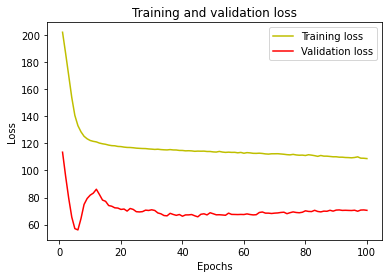


Predicted values are: 
 [[8.671626 ]
 [6.678319 ]
 [5.074336 ]
 [4.4550037]
 [6.4623246]]

Real values are: 
 21061     4.683
21086    11.929
21123     1.908
21151     6.102
21155    14.305
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 56.4712 - mean_absolute_error: 5.3922

Mean squared error from neural net: 
 56.471195220947266

Mean absolute error from neural net: 
 5.392200469970703

Predicted values are:
  [[0.00301869 0.00298265 0.00290086 ... 0.00309155 0.00320213 0.00305731]
 [0.00300242 0.0029764  0.00291489 ... 0.003062   0.00314389 0.00303253]
 [0.00297978 0.00296719 0.00293449 ... 0.00300708 0.00304134 0.00299597]
 [0.00297137 0.00296495 0.00294125 ... 0.00298741 0.00300291 0.00298006]
 [0.00295919 0.00296197 0.00295547 ... 0.00296273 0.0029649  0.00296203]]

Real values are: 
 21061     4.683
21086    11.929
21123     1.908
21151     6.102
21155    14.305
Name: kWhDelivered, dtype: float64
1/1 [=============================

In [700]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 56.471195220947266

Mean absolute error from neural net: 
 5.392200469970703

Mean squared error using decision tree:  63.436427124999994

Mean absolute error using decision tree:  5.284375000000001


# Space CA-500

# 1 month of training data to predict the demand of 1 space for 1 day

In [701]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [702]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [703]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [704]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_491 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_492 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_493 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 370ms/step - loss: 103.2200 - mean_absolute_error: 8.0172 - val_loss: 67.4997 - val_mean_absolute_error: 6.4153
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 101.6388 - mean_absolute_error: 7.9280 - val_loss: 65.5847 - val_mean_absolute_error: 6.2662
Epoch 3/100
1/1 [==============================] 

1/1 [==============================] - 0s 19ms/step - loss: 22.6799 - mean_absolute_error: 4.1917 - val_loss: 449.3401 - val_mean_absolute_error: 20.1579
Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 22.5725 - mean_absolute_error: 4.1804 - val_loss: 446.7312 - val_mean_absolute_error: 20.0838
Epoch 97/100
1/1 [==============================] - 0s 19ms/step - loss: 22.4672 - mean_absolute_error: 4.1691 - val_loss: 444.0735 - val_mean_absolute_error: 20.0084
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 22.3659 - mean_absolute_error: 4.1577 - val_loss: 441.3905 - val_mean_absolute_error: 19.9323
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 22.2690 - mean_absolute_error: 4.1464 - val_loss: 438.7230 - val_mean_absolute_error: 19.8564
Epoch 100/100
1/1 [==============================] - 0s 20ms/step - loss: 22.1687 - mean_absolute_error: 4.1344 - val_loss: 436.0977 - val_mean_absolute_error: 19.7816


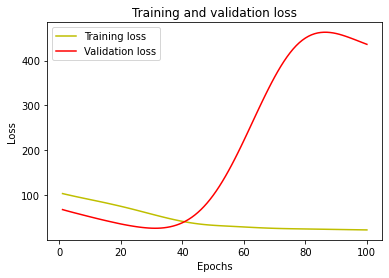


Predicted values are: 
 [[3.990834]]

Real values are: 
 16317    11.416
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 55.1331 - mean_absolute_error: 7.4252

Mean squared error from neural net: 
 55.13309097290039

Mean absolute error from neural net: 
 7.425166130065918

Predicted values are:
  [[0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
  0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
  0.07692308]]

Real values are: 
 16317    11.416
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 160ms/step - loss: 128.5747 - mean_absolute_error: 11.3391

Mean squared error from Convolutional neural net:  128.5746612548828

Mean absolute error from Convolutional neural net:  11.33907699584961

Mean squared error from linear regression:  14.204201329055056

Mean absolute error from linear regression:  3.768846153540239

Mean squared error using decision tree:  33.48936900000001



In [705]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  14.204201329055056

Mean absolute error from linear regression:  3.768846153540239

Mean squared error using Random Forest:  16.960477256099956

Mean absolute error Using Random Forest:  4.118309999999995


# 1 Month to predict 1 week

In [706]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [707]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [708]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [709]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_496 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_497 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_498 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 371ms/step - loss: 108.9307 - mean_absolute_error: 9.0648 - val_loss: 190.0057 - val_mean_absolute_error: 11.7977
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 107.4995 - mean_absolute_error: 8.9782 - val_loss: 186.1218 - val_mean_absolute_error: 11.6233
Epoch 3/100
1/1 [============================

Epoch 46/100
1/1 [==============================] - 0s 19ms/step - loss: 48.1029 - mean_absolute_error: 5.3199 - val_loss: 65.0407 - val_mean_absolute_error: 7.7447
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 47.2892 - mean_absolute_error: 5.2817 - val_loss: 65.5554 - val_mean_absolute_error: 7.8724
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 46.5405 - mean_absolute_error: 5.2418 - val_loss: 66.4062 - val_mean_absolute_error: 8.0006
Epoch 49/100
1/1 [==============================] - 0s 19ms/step - loss: 45.8528 - mean_absolute_error: 5.2000 - val_loss: 67.5879 - val_mean_absolute_error: 8.1288
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 45.2198 - mean_absolute_error: 5.1563 - val_loss: 69.0902 - val_mean_absolute_error: 8.2564
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 44.6378 - mean_absolute_error: 5.1143 - val_loss: 70.8973 - val_mean_absolute_error: 8.3831
Epoch 52/1

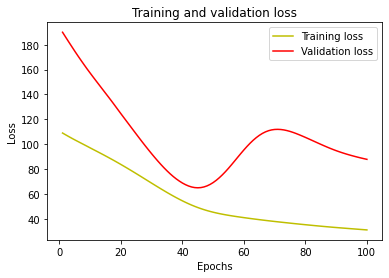


Predicted values are: 
 [[13.506096 ]
 [ 9.36414  ]
 [ 4.2123227]
 [ 9.521168 ]
 [16.531988 ]]

Real values are: 
 4041    9.723
4054    5.410
4117    7.793
4190    7.465
4247    5.980
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 31.6681 - mean_absolute_error: 4.7852

Mean squared error from neural net: 
 31.668115615844727

Mean absolute error from neural net: 
 4.785213470458984

Predicted values are:
  [[0.03876035 0.03652238 0.04453584 0.03902169 0.04064883 0.04062917
  0.03815999 0.04087734 0.03963454 0.04020243 0.04659783 0.03473363
  0.03714256 0.0414807  0.04333865 0.04007313 0.04159234 0.04163522
  0.03848573 0.03920012 0.04322599 0.035011   0.04072493 0.04008633
  0.03767936]
 [0.03878006 0.03690434 0.04368661 0.03952002 0.0411012  0.04052356
  0.03852717 0.04038063 0.03958574 0.03994917 0.0451115  0.03562513
  0.03707074 0.04138194 0.0427565  0.04027928 0.04130623 0.0413749
  0.03837367 0.03965992 0.04318247 0.03559573 0.040

In [710]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  12.604990430210952

Mean absolute error from linear regression:  3.255140440702533

Mean squared error using Random Forest:  12.571779641319988

Mean absolute error Using Random Forest:  3.0359519999999995


# 6 Month training 1 week predicition

In [711]:
train = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [712]:
test = DataFrameDict['CA-500'].loc[DataFrameDict['CA-500']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [713]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [714]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_501 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_502 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_503 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 55ms/step - loss: 115.5478 - mean_absolute_error: 8.2067 - val_loss: 88.4704 - val_mean_absolute_error: 7.9130
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 111.5428 - mean_absolute_error: 7.9950 - val_loss: 84.4812 - val_mean_absolute_error: 7.6780
Epoch 3/100
3/3 [==============================] -

3/3 [==============================] - 0s 9ms/step - loss: 40.0042 - mean_absolute_error: 4.6937 - val_loss: 41.9138 - val_mean_absolute_error: 5.2167
Epoch 97/100
3/3 [==============================] - 0s 9ms/step - loss: 39.8948 - mean_absolute_error: 4.6728 - val_loss: 41.3455 - val_mean_absolute_error: 5.1773
Epoch 98/100
3/3 [==============================] - 0s 10ms/step - loss: 39.9282 - mean_absolute_error: 4.6812 - val_loss: 40.7273 - val_mean_absolute_error: 5.1337
Epoch 99/100
3/3 [==============================] - 0s 9ms/step - loss: 39.8485 - mean_absolute_error: 4.6720 - val_loss: 40.3773 - val_mean_absolute_error: 5.1070
Epoch 100/100
3/3 [==============================] - 0s 9ms/step - loss: 39.8680 - mean_absolute_error: 4.6635 - val_loss: 40.1822 - val_mean_absolute_error: 5.0883


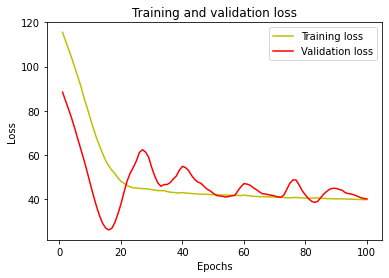


Predicted values are: 
 [[3.5881786]]

Real values are: 
 21073    3.409
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 0.0321 - mean_absolute_error: 0.1792

Mean squared error from neural net: 
 0.032105010002851486

Mean absolute error from neural net: 
 0.17917871475219727

Predicted values are:
  [[0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
  0.01123596 0.01123596 0.01123596 0.

In [715]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 0.032105010002851486

Mean absolute error from neural net: 
 0.17917871475219727

 Mean squared error using Random Forest:  5.182679902499998

Mean absolute error Using Random Forest:  2.2765499999999994

# Space CA-506

# 1 month of training data to predict the demand of 1 space for 1 day

In [716]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [717]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [718]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [719]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_506 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_507 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_508 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 674ms/step - loss: 119.5387 - mean_absolute_error: 10.9273 - val_loss: 37.2288 - val_mean_absolute_error: 6.1015
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 116.8352 - mean_absolute_error: 10.8013 - val_loss: 36.7890 - val_mean_absolute_error: 6.0654
Epoch 3/100
1/1 [==============================

1/1 [==============================] - 0s 17ms/step - loss: 24.5797 - mean_absolute_error: 4.3341 - val_loss: 13.2121 - val_mean_absolute_error: 3.6349
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 22.8568 - mean_absolute_error: 4.1137 - val_loss: 12.4343 - val_mean_absolute_error: 3.5262
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 21.2028 - mean_absolute_error: 3.8926 - val_loss: 11.6582 - val_mean_absolute_error: 3.4144
Epoch 49/100
1/1 [==============================] - 0s 16ms/step - loss: 19.6186 - mean_absolute_error: 3.6708 - val_loss: 10.8902 - val_mean_absolute_error: 3.3000
Epoch 50/100
1/1 [==============================] - 0s 19ms/step - loss: 18.1078 - mean_absolute_error: 3.4496 - val_loss: 10.1340 - val_mean_absolute_error: 3.1834
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 16.6712 - mean_absolute_error: 3.2297 - val_loss: 9.3829 - val_mean_absolute_error: 3.0631
Epoch 52/100
1/1 [======

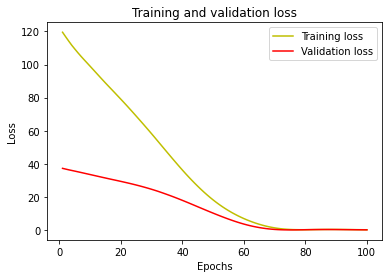


Predicted values are: 
 [[2.0403645]]

Real values are: 
 16308    10.514
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 16ms/step - loss: 71.8025 - mean_absolute_error: 8.4736

Mean squared error from neural net: 
 71.80249786376953

Mean absolute error from neural net: 
 8.47363567352295

Predicted values are:
  [[0.33333334 0.33333334 0.33333334]]

Real values are: 
 16308    10.514
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 158ms/step - loss: 103.6460 - mean_absolute_error: 10.1807

Mean squared error from Convolutional neural net:  103.6459732055664

Mean absolute error from Convolutional neural net:  10.18066692352295

Mean squared error from linear regression:  1.1427609999996637

Mean absolute error from linear regression:  1.0689999999998427

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281

In [720]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  1.1427609999996637

Mean absolute error from linear regression:  1.0689999999998427

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

# 1 Month to predict 1 week

In [721]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 5]

In [722]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [723]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [724]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_511 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_512 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_513 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 352ms/step - loss: 39.7537 - mean_absolute_error: 5.4014 - val_loss: 117.9285 - val_mean_absolute_error: 10.3414
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 38.7975 - mean_absolute_error: 5.3189 - val_loss: 116.7440 - val_mean_absolute_error: 10.2823
Epoch 3/100
1/1 [==============================

1/1 [==============================] - 0s 17ms/step - loss: 9.0699 - mean_absolute_error: 2.5555 - val_loss: 79.6014 - val_mean_absolute_error: 8.3277
Epoch 47/100
1/1 [==============================] - 0s 18ms/step - loss: 8.9567 - mean_absolute_error: 2.5271 - val_loss: 78.9964 - val_mean_absolute_error: 8.2945
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 8.8295 - mean_absolute_error: 2.5093 - val_loss: 78.4234 - val_mean_absolute_error: 8.2641
Epoch 49/100
1/1 [==============================] - 0s 20ms/step - loss: 8.6893 - mean_absolute_error: 2.4900 - val_loss: 77.8783 - val_mean_absolute_error: 8.2357
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 8.5352 - mean_absolute_error: 2.4692 - val_loss: 77.3591 - val_mean_absolute_error: 8.2093
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 8.3706 - mean_absolute_error: 2.4470 - val_loss: 76.8667 - val_mean_absolute_error: 8.1849
Epoch 52/100
1/1 [===========

1/1 [==============================] - 0s 17ms/step - loss: 4.5765 - mean_absolute_error: 1.8193 - val_loss: 59.2630 - val_mean_absolute_error: 7.2700
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 4.5497 - mean_absolute_error: 1.8112 - val_loss: 59.1890 - val_mean_absolute_error: 7.2667
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 4.5197 - mean_absolute_error: 1.8027 - val_loss: 59.1250 - val_mean_absolute_error: 7.2642
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 4.4918 - mean_absolute_error: 1.7945 - val_loss: 59.0784 - val_mean_absolute_error: 7.2630
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 4.4684 - mean_absolute_error: 1.7863 - val_loss: 59.0540 - val_mean_absolute_error: 7.2635


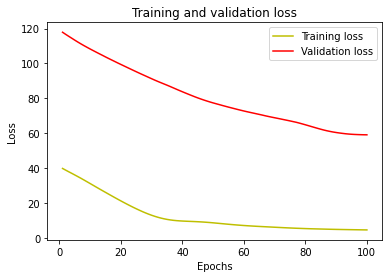


Predicted values are: 
 [[15.570485 ]
 [ 2.9403615]
 [ 1.7762469]
 [ 1.7753745]]

Real values are: 
 2081    2.726
2210    8.532
2279    8.096
2304    4.419
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 60.7938 - mean_absolute_error: 6.8499

Mean squared error from neural net: 
 60.79380416870117

Mean absolute error from neural net: 
 6.849874973297119

Predicted values are:
  [[0.16218162 0.14372693 0.15156996 0.12598749 0.14355901 0.13161543
  0.14135963]
 [0.14763162 0.14310504 0.1402659  0.13683103 0.14547285 0.14471658
  0.14197695]
 [0.1536691  0.1449621  0.13759449 0.13009162 0.14439416 0.15468939
  0.13459915]
 [0.1543612  0.14479108 0.13690332 0.12937456 0.14418127 0.1567697
  0.13361877]]

Real values are: 
 2081    2.726
2210    8.532
2279    8.096
2304    4.419
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 161ms/step - loss: 39.6471 - mean_absolute_error: 5.8004

Mean squared error from Convol

In [725]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  35.37149025

Mean absolute error using decision tree:  5.46175

Mean squared error using Random Forest:  19.23394901477499

Mean absolute error Using Random Forest:  3.589812499999998

# 6 Month training 1 week predicition

In [726]:
train = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([5,6,7,8,9,10])]

In [727]:
test = DataFrameDict['CA-506'].loc[DataFrameDict['CA-506']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 12]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [728]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [729]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_516 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_517 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_518 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 366ms/step - loss: 44.7397 - mean_absolute_error: 6.2785 - val_loss: 19.2374 - val_mean_absolute_error: 4.3848
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 43.4374 - mean_absolute_error: 6.1753 - val_loss: 18.7122 - val_mean_absolute_error: 4.3246
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 17ms/step - loss: 4.4929 - mean_absolute_error: 1.7009 - val_loss: 3.9112 - val_mean_absolute_error: 1.8448
Epoch 97/100
1/1 [==============================] - 0s 49ms/step - loss: 4.4712 - mean_absolute_error: 1.6961 - val_loss: 3.8997 - val_mean_absolute_error: 1.8404
Epoch 98/100
1/1 [==============================] - 0s 23ms/step - loss: 4.4494 - mean_absolute_error: 1.6912 - val_loss: 3.8903 - val_mean_absolute_error: 1.8366
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 4.4278 - mean_absolute_error: 1.6863 - val_loss: 3.8782 - val_mean_absolute_error: 1.8313
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 4.4053 - mean_absolute_error: 1.6815 - val_loss: 3.8684 - val_mean_absolute_error: 1.8267


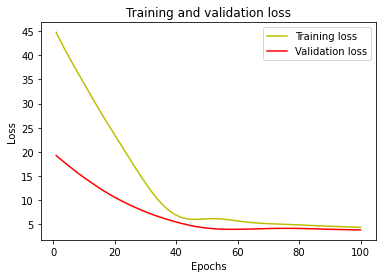


Predicted values are: 
 [[1.5095445]]

Real values are: 
 25279    6.238
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 22.3583 - mean_absolute_error: 4.7285

Mean squared error from neural net: 
 22.358291625976562

Mean absolute error from neural net: 
 4.728455543518066

Predicted values are:
  [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]]

Real values are: 
 25279    6.238
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 170ms/step - loss: 36.8611 - mean_absolute_error: 6.0713

Mean squared error from Convolutional neural net:  36.861087799072266

Mean absolute error from Convolutional neural net:  6.071333408355713

Mean squared error from linear regression:  0.6408002499528751

Mean absolute error from linear regression:  0.8004999999705653

Mean squared error using decision tree:  1.8577690000000011

Mean absolute error using decision tree:  1.3630000000000004

Mean squared error

In [730]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  0.6408002499528751

Mean absolute error from linear regression:  0.8004999999705653

Mean squared error using decision tree:  1.8577690000000011

Mean absolute error using decision tree:  1.3630000000000004

Mean squared error using Random Forest:  2.1081007249000074

Mean absolute error Using Random Forest:  1.4519300000000026

# Space 513

# 1 month of training data to predict the demand of 1 space for 1 day

In [731]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [732]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [733]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [734]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_521 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_522 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_523 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 373ms/step - loss: 105.2623 - mean_absolute_error: 9.1500 - val_loss: 88.3169 - val_mean_absolute_error: 8.7305
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 103.8213 - mean_absolute_error: 9.0654 - val_loss: 86.7891 - val_mean_absolute_error: 8.6440
Epoch 3/100
1/1 [==============================] 

1/1 [==============================] - 0s 17ms/step - loss: 23.9542 - mean_absolute_error: 3.9994 - val_loss: 389.7910 - val_mean_absolute_error: 19.1069
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 23.8683 - mean_absolute_error: 3.9877 - val_loss: 397.6308 - val_mean_absolute_error: 19.3115
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 23.7761 - mean_absolute_error: 3.9752 - val_loss: 404.7104 - val_mean_absolute_error: 19.4958
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 23.6787 - mean_absolute_error: 3.9621 - val_loss: 411.0549 - val_mean_absolute_error: 19.6608
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 23.5786 - mean_absolute_error: 3.9484 - val_loss: 416.6144 - val_mean_absolute_error: 19.8059
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 23.4758 - mean_absolute_error: 3.9347 - val_loss: 421.5074 - val_mean_absolute_error: 19.9341


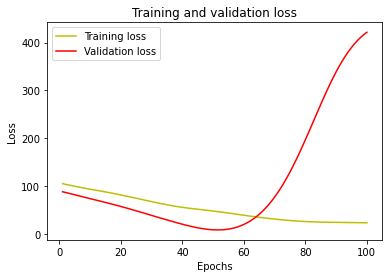


Predicted values are: 
 [[4.7177444]]

Real values are: 
 10736    6.491
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 15ms/step - loss: 3.1444 - mean_absolute_error: 1.7733

Mean squared error from neural net: 
 3.1444361209869385

Mean absolute error from neural net: 
 1.7732558250427246

Predicted values are:
  [[0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
  0.04761905 0.04761905 0.04761905]]

Real values are: 
 10736    6.491
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 159ms/step - loss: 41.5172 - mean_absolute_error: 6.4434

Mean squared error from Convolutional neural net:  41.51716232299805

Mean absolute error from Convolutional neural net:  6.443381309509277

Mean squared error from linear regression:  7.335069444498013

Mean absolute error from linear regre

In [735]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 3.1444361209869385

Mean absolute error from neural net: 
 1.7732558250427246

 Mean squared error from linear regression:  7.335069444498013

Mean absolute error from linear regression:  2.708333333343223

# 1 Month to predict 1 week

In [736]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_month'] == 5]
train = train.loc[train['connectionTime_year'] == 2018]

In [737]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 6]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [739]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [740]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_526 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_527 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_528 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 353ms/step - loss: 131.6762 - mean_absolute_error: 10.9514 - val_loss: 51.8223 - val_mean_absolute_error: 6.1517
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 129.8867 - mean_absolute_error: 10.8738 - val_loss: 51.2367 - val_mean_absolute_error: 6.1044
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 30.4602 - mean_absolute_error: 4.4859 - val_loss: 36.6251 - val_mean_absolute_error: 4.7566
Epoch 47/100
1/1 [==============================] - 0s 20ms/step - loss: 28.3454 - mean_absolute_error: 4.2843 - val_loss: 36.6328 - val_mean_absolute_error: 4.7578
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 26.3815 - mean_absolute_error: 4.0801 - val_loss: 36.6010 - val_mean_absolute_error: 4.7558
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 24.5843 - mean_absolute_error: 3.8742 - val_loss: 36.5885 - val_mean_absolute_error: 4.7549
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 22.9637 - mean_absolute_error: 3.6674 - val_loss: 36.5935 - val_mean_absolute_error: 4.7547
Epoch 51/100
1/1 [==============================] - 0s 17ms/step - loss: 21.5243 - mean_absolute_error: 3.4681 - val_loss: 36.6167 - val_mean_absolute_error: 4.7553
Epoch 52/1

Epoch 96/100
1/1 [==============================] - 0s 18ms/step - loss: 12.7962 - mean_absolute_error: 2.6202 - val_loss: 27.8974 - val_mean_absolute_error: 4.1465
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 12.7095 - mean_absolute_error: 2.6159 - val_loss: 27.7170 - val_mean_absolute_error: 4.1288
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 12.6258 - mean_absolute_error: 2.6124 - val_loss: 27.5384 - val_mean_absolute_error: 4.1110
Epoch 99/100
1/1 [==============================] - 0s 45ms/step - loss: 12.5429 - mean_absolute_error: 2.6093 - val_loss: 27.3682 - val_mean_absolute_error: 4.0941
Epoch 100/100
1/1 [==============================] - 0s 21ms/step - loss: 12.4601 - mean_absolute_error: 2.6065 - val_loss: 27.2062 - val_mean_absolute_error: 4.0782


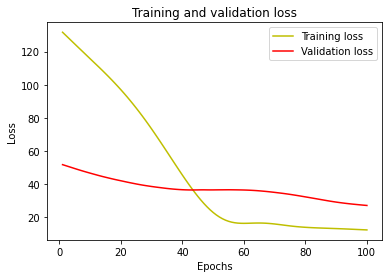


Predicted values are: 
 [[19.10602  ]
 [13.400815 ]
 [ 6.400509 ]
 [ 5.710906 ]
 [ 2.7743459]]

Real values are: 
 2114     9.910
2149    13.516
2185     3.923
2190     1.895
2282    12.412
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 35.0863 - mean_absolute_error: 4.7929

Mean squared error from neural net: 
 35.08634567260742

Mean absolute error from neural net: 
 4.792860984802246

Predicted values are:
  [[0.06313869 0.05349342 0.0581332  0.04732106 0.05980266 0.06248315
  0.06022044 0.06672059 0.06610175 0.06736074 0.06106019 0.07335134
  0.05669064 0.06628726 0.06792723 0.06990767]
 [0.06141644 0.05960467 0.06119546 0.05455979 0.05916419 0.06324022
  0.0601718  0.06627124 0.06445315 0.06259004 0.06313242 0.06751524
  0.05891203 0.06415526 0.0653422  0.06827587]
 [0.06368673 0.06000382 0.06298272 0.05900528 0.05975883 0.06204772
  0.0616717  0.06524409 0.06246121 0.06110658 0.06334778 0.06245556
  0.06067819 0.06452    0.06483514

In [741]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  24.543271833333336

Mean absolute error using decision tree:  3.8541666666666665

Mean squared error using Random Forest:  15.096384583916661

Mean absolute error Using Random Forest:  3.297375000000001


# 6 Month training 1 week predicition

In [742]:
train = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [743]:
test = DataFrameDict['CA-513'].loc[DataFrameDict['CA-513']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [745]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [746]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_531 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_532 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_533 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 108ms/step - loss: 123.2302 - mean_absolute_error: 9.4478 - val_loss: 108.9076 - val_mean_absolute_error: 9.8482
Epoch 2/100
2/2 [==============================] - 0s 19ms/step - loss: 118.8933 - mean_absolute_error: 9.2168 - val_loss: 103.1467 - val_mean_absolute_error: 9.5478
Epoch 3/100
2/2 [==============================

Epoch 96/100
2/2 [==============================] - 0s 17ms/step - loss: 26.7593 - mean_absolute_error: 4.1280 - val_loss: 34.1250 - val_mean_absolute_error: 4.8621
Epoch 97/100
2/2 [==============================] - 0s 17ms/step - loss: 26.7230 - mean_absolute_error: 4.1227 - val_loss: 35.1504 - val_mean_absolute_error: 4.9325
Epoch 98/100
2/2 [==============================] - 0s 17ms/step - loss: 26.7714 - mean_absolute_error: 4.1201 - val_loss: 36.9672 - val_mean_absolute_error: 5.0516
Epoch 99/100
2/2 [==============================] - 0s 18ms/step - loss: 26.7198 - mean_absolute_error: 4.1120 - val_loss: 38.1091 - val_mean_absolute_error: 5.1247
Epoch 100/100
2/2 [==============================] - 0s 17ms/step - loss: 26.6784 - mean_absolute_error: 4.1056 - val_loss: 38.7095 - val_mean_absolute_error: 5.1636


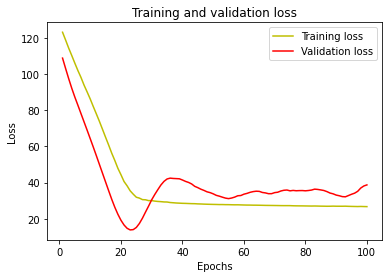


Predicted values are: 
 [[11.950584 ]
 [ 6.661583 ]
 [ 2.6193345]
 [ 6.789591 ]
 [10.822814 ]]

Real values are: 
 10736    6.491
10841    6.660
10929    5.551
11021    8.390
11046    6.108
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 12.1831 - mean_absolute_error: 2.9759

Mean squared error from neural net: 
 12.183110237121582

Mean absolute error from neural net: 
 2.9759104251861572

Predicted values are:
  [[0.01528948 0.02103827 0.01370455 0.01454273 0.01678404 0.01619411
  0.01408849 0.01608461 0.01564516 0.01404343 0.016109   0.01509384
  0.01308851 0.01605698 0.01399097 0.01525214 0.01556401 0.01518902
  0.01681277 0.0165367  0.0115443  0.01732369 0.01742683 0.0135632
  0.01466052 0.01536006 0.01725385 0.01630648 0.01475352 0.01567529
  0.01569632 0.01556036 0.01759643 0.01673364 0.0178372  0.01381643
  0.01526404 0.01767233 0.01553739 0.01522216 0.01779696 0.01495623
  0.01685439 0.01288506 0.01390632 0.01452532 0.0174493  0.

In [747]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 12.183110237121582

Mean absolute error from neural net: 
 2.9759104251861572

 Mean squared error using Random Forest:  6.5244852854166595

Mean absolute error Using Random Forest:  2.207621666666666

# Space CA-212

# 1 month of training data to predict the demand of 1 space for 1 day

In [749]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
train = train.loc[train['connectionTime_month'] == 1]

In [750]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2020]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [751]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [752]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_213"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_536 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_537 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_538 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 665ms/step - loss: 0.9524 - mean_absolute_error: 0.9759 - val_loss: 33.6418 - val_mean_absolute_error: 5.8002
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.7192 - mean_absolute_error: 0.8480 - val_loss: 33.5545 - val_mean_absolute_error: 5.7926
Epoch 3/100
1/1 [==============================] - 0s

Epoch 95/100
1/1 [==============================] - 0s 20ms/step - loss: 1.7530e-05 - mean_absolute_error: 0.0042 - val_loss: 32.8661 - val_mean_absolute_error: 5.7329
Epoch 96/100
1/1 [==============================] - 0s 20ms/step - loss: 1.7729e-05 - mean_absolute_error: 0.0042 - val_loss: 32.8660 - val_mean_absolute_error: 5.7329
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 1.6174e-05 - mean_absolute_error: 0.0040 - val_loss: 32.8657 - val_mean_absolute_error: 5.7329
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 1.3316e-05 - mean_absolute_error: 0.0036 - val_loss: 32.8654 - val_mean_absolute_error: 5.7328
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 9.7825e-06 - mean_absolute_error: 0.0031 - val_loss: 32.8651 - val_mean_absolute_error: 5.7328
Epoch 100/100
1/1 [==============================] - 0s 16ms/step - loss: 6.2345e-06 - mean_absolute_error: 0.0025 - val_loss: 32.8647 - val_mean_absolute_error

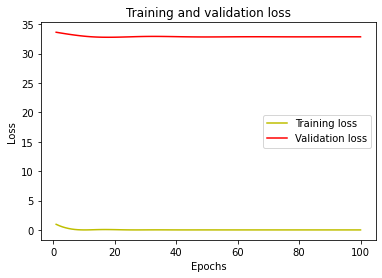


Predicted values are: 
 [[0.05799637]]

Real values are: 
 26735    0.658
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 0.3600 - mean_absolute_error: 0.6000

Mean squared error from neural net: 
 0.3600043058395386

Mean absolute error from neural net: 
 0.6000036001205444

Predicted values are:
  [[0.5 0.5]]

Real values are: 
 26735    0.658
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 163ms/step - loss: 0.0250 - mean_absolute_error: 0.1580

Mean squared error from Convolutional neural net:  0.024963997304439545

Mean absolute error from Convolutional neural net:  0.15799999237060547

Mean squared error from linear regression:  6.46430625

Mean absolute error from linear regression:  2.5425

Mean squared error using decision tree:  0.027224999999999975

Mean absolute error using decision tree:  0.16499999999999992

Mean squared error using Random Forest:  2.532872250000001

Mean absolute error Using Ran

In [753]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from Convolutional neural net:  0.024963997304439545

Mean absolute error from Convolutional neural net:  0.15799999237060547

Mean squared error using decision tree:  0.027224999999999975

Mean absolute error using decision tree:  0.16499999999999992

# 1 Month to predict 1 week

In [754]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_month'] == 9]
train = train.loc[train['connectionTime_year'] == 2018]

In [755]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [756]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [757]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_541 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_542 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_543 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 350ms/step - loss: 104.3646 - mean_absolute_error: 9.4378 - val_loss: 33.2713 - val_mean_absolute_error: 4.4716
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 103.0487 - mean_absolute_error: 9.3674 - val_loss: 32.6004 - val_mean_absolute_error: 4.3920
Epoch 3/100
1/1 [==============================] 

1/1 [==============================] - 0s 18ms/step - loss: 20.3860 - mean_absolute_error: 3.7385 - val_loss: 249.6251 - val_mean_absolute_error: 14.0427
Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 19.9606 - mean_absolute_error: 3.6838 - val_loss: 256.8184 - val_mean_absolute_error: 14.2510
Epoch 97/100
1/1 [==============================] - 0s 18ms/step - loss: 19.5438 - mean_absolute_error: 3.6278 - val_loss: 264.1927 - val_mean_absolute_error: 14.4630
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 19.1320 - mean_absolute_error: 3.5706 - val_loss: 271.7170 - val_mean_absolute_error: 14.6771
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 18.7282 - mean_absolute_error: 3.5123 - val_loss: 279.3799 - val_mean_absolute_error: 14.8933
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 18.3382 - mean_absolute_error: 3.4540 - val_loss: 287.1050 - val_mean_absolute_error: 15.1084


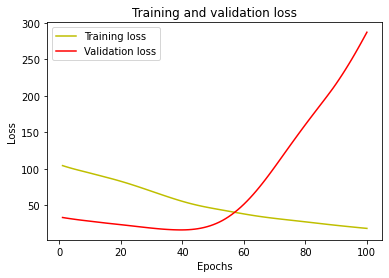


Predicted values are: 
 [[ 7.308299 ]
 [ 7.1764994]
 [ 5.2923336]
 [ 4.1968603]
 [20.524796 ]]

Real values are: 
 10739     3.217
10745     8.842
10830    10.685
10930    13.880
11160    13.886
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 96.3637 - mean_absolute_error: 7.8774

Mean squared error from neural net: 
 96.36365509033203

Mean absolute error from neural net: 
 7.877353191375732

Predicted values are:
  [[0.08542803 0.07731912 0.08436008 0.08416923 0.08278897 0.07443527
  0.08930907 0.07886745 0.06880799 0.08605924 0.09248995 0.09596556]
 [0.08534034 0.07764092 0.08431052 0.08424752 0.08279836 0.07489613
  0.08891131 0.07904323 0.0695149  0.0859437  0.09203009 0.09532301]
 [0.08498511 0.08019199 0.08378465 0.08402478 0.08290767 0.07830939
  0.08618047 0.08126293 0.07517026 0.0846946  0.08830125 0.09018692]
 [0.08394707 0.08248392 0.08328809 0.08355322 0.08320116 0.08210514
  0.08388045 0.08294228 0.08130386 0.08365075 0.0846

In [758]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error using decision tree:  44.092632864562965

Mean absolute error using decision tree:  5.49582888888889

Mean squared error using Random Forest:  28.01973215874843

Mean absolute error Using Random Forest:  4.55962271111111

# 6 Month training 1 week predicition

In [759]:
train = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [760]:
test = DataFrameDict['CA-212'].loc[DataFrameDict['CA-212']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [761]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [762]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_546 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_547 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_548 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 102ms/step - loss: 171.8804 - mean_absolute_error: 10.6340 - val_loss: 18.2443 - val_mean_absolute_error: 3.7406
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 168.4634 - mean_absolute_error: 10.4719 - val_loss: 16.6682 - val_mean_absolute_error: 3.5095
Epoch 3/100
2/2 [==============================

2/2 [==============================] - 0s 17ms/step - loss: 52.1831 - mean_absolute_error: 5.2777 - val_loss: 47.9436 - val_mean_absolute_error: 5.8515
Epoch 47/100
2/2 [==============================] - 0s 18ms/step - loss: 52.0050 - mean_absolute_error: 5.2846 - val_loss: 47.5346 - val_mean_absolute_error: 5.8299
Epoch 48/100
2/2 [==============================] - 0s 18ms/step - loss: 51.7921 - mean_absolute_error: 5.2853 - val_loss: 47.2724 - val_mean_absolute_error: 5.8164
Epoch 49/100
2/2 [==============================] - 0s 18ms/step - loss: 51.6437 - mean_absolute_error: 5.2886 - val_loss: 46.9075 - val_mean_absolute_error: 5.7940
Epoch 50/100
2/2 [==============================] - 0s 17ms/step - loss: 51.5521 - mean_absolute_error: 5.2914 - val_loss: 46.6535 - val_mean_absolute_error: 5.7800
Epoch 51/100
2/2 [==============================] - 0s 17ms/step - loss: 51.3641 - mean_absolute_error: 5.2882 - val_loss: 46.6308 - val_mean_absolute_error: 5.7822
Epoch 52/100
2/2 [=====

Epoch 96/100
2/2 [==============================] - 0s 19ms/step - loss: 47.2603 - mean_absolute_error: 5.0180 - val_loss: 27.6288 - val_mean_absolute_error: 3.9345
Epoch 97/100
2/2 [==============================] - 0s 19ms/step - loss: 47.1966 - mean_absolute_error: 5.0156 - val_loss: 27.0711 - val_mean_absolute_error: 3.8786
Epoch 98/100
2/2 [==============================] - 0s 17ms/step - loss: 47.1264 - mean_absolute_error: 5.0112 - val_loss: 26.4793 - val_mean_absolute_error: 3.8179
Epoch 99/100
2/2 [==============================] - 0s 18ms/step - loss: 47.0751 - mean_absolute_error: 5.0079 - val_loss: 25.9212 - val_mean_absolute_error: 3.7591
Epoch 100/100
2/2 [==============================] - 0s 16ms/step - loss: 46.9926 - mean_absolute_error: 5.0029 - val_loss: 25.3122 - val_mean_absolute_error: 3.6932


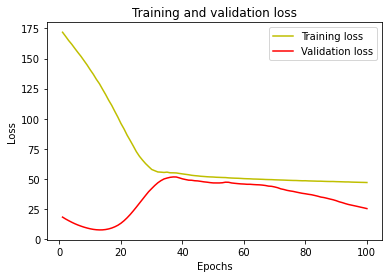


Predicted values are: 
 [[4.791772]]

Real values are: 
 21135    1.029
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 14.1585 - mean_absolute_error: 3.7628

Mean squared error from neural net: 
 14.158452033996582

Mean absolute error from neural net: 
 3.7627718448638916

Predicted values are:
  [[0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.01538462 0.01538462 0.01538462
  0.01538462 0.01538462 0.01538462 0.015

In [763]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 14.158452033996582

Mean absolute error from neural net: 
 3.7627718448638916

Mean squared error from Convolutional neural net:  1.0274161100387573

Mean absolute error from Convolutional neural net:  1.013615369796753

Mean squared error using decision tree:  0.01742399999999997

Mean absolute error using decision tree:  0.1319999999999999


# Space CA-310

# 1 month of training data to predict the demand of 1 space for 1 day

In [764]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
train = train.loc[train['connectionTime_month'] == 1]

In [765]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 2]
test = test.loc[test['connectionTime_day'] == 1]

In [766]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [767]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_219"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_551 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_552 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_553 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 363ms/step - loss: 57.4666 - mean_absolute_error: 5.4566 - val_loss: 83.5746 - val_mean_absolute_error: 7.2294
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 56.2806 - mean_absolute_error: 5.3580 - val_loss: 81.6530 - val_mean_absolute_error: 7.0631
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 18ms/step - loss: 0.0927 - mean_absolute_error: 0.2067 - val_loss: 295.4770 - val_mean_absolute_error: 12.4351
Epoch 96/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0923 - mean_absolute_error: 0.2095 - val_loss: 294.7415 - val_mean_absolute_error: 12.4068
Epoch 97/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0911 - mean_absolute_error: 0.2111 - val_loss: 294.3110 - val_mean_absolute_error: 12.3884
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0889 - mean_absolute_error: 0.2103 - val_loss: 294.1617 - val_mean_absolute_error: 12.3793
Epoch 99/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0859 - mean_absolute_error: 0.2073 - val_loss: 294.2677 - val_mean_absolute_error: 12.3785
Epoch 100/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0820 - mean_absolute_error: 0.2022 - val_loss: 294.6012 - val_mean_absolute_error: 12.3853


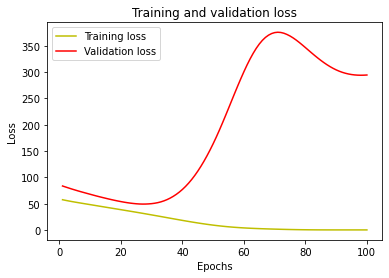


Predicted values are: 
 [[2.7487242]]

Real values are: 
 16329    1.57
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 1.3894 - mean_absolute_error: 1.1787

Mean squared error from neural net: 
 1.3893907070159912

Mean absolute error from neural net: 
 1.1787241697311401

Predicted values are:
  [[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
  0.11111111 0.11111111 0.11111111]]

Real values are: 
 16329    1.57
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 155ms/step - loss: 2.1284 - mean_absolute_error: 1.4589

Mean squared error from Convolutional neural net:  2.128356695175171

Mean absolute error from Convolutional neural net:  1.4588888883590698

Mean squared error from linear regression:  19.45888149383735

Mean absolute error from linear regression:  4.411222222223377

Mean squared error using decision tree:  146.1681

Mean absolute error using decision tree:  12.09

Mean square

In [768]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 1.3893907070159912

Mean absolute error from neural net: 
 1.1787241697311401

Mean squared error from Convolutional neural net:  2.128356695175171

Mean absolute error from Convolutional neural net:  1.4588888883590698


# 1 Month to predict 1 week

In [769]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [770]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [771]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [772]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_556 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_557 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_558 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 356ms/step - loss: 81.7050 - mean_absolute_error: 7.8287 - val_loss: 81.1291 - val_mean_absolute_error: 7.3115
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 80.3915 - mean_absolute_error: 7.7458 - val_loss: 79.3526 - val_mean_absolute_error: 7.1886
Epoch 3/100
1/1 [==============================] - 

Epoch 96/100
1/1 [==============================] - 0s 17ms/step - loss: 21.3543 - mean_absolute_error: 3.9680 - val_loss: 90.0394 - val_mean_absolute_error: 8.2195
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 21.3190 - mean_absolute_error: 3.9686 - val_loss: 89.9909 - val_mean_absolute_error: 8.2191
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 21.2838 - mean_absolute_error: 3.9688 - val_loss: 89.9872 - val_mean_absolute_error: 8.2207
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 21.2495 - mean_absolute_error: 3.9686 - val_loss: 90.0279 - val_mean_absolute_error: 8.2242
Epoch 100/100
1/1 [==============================] - 0s 18ms/step - loss: 21.2155 - mean_absolute_error: 3.9681 - val_loss: 90.0771 - val_mean_absolute_error: 8.2282


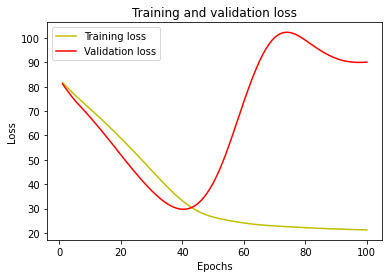


Predicted values are: 
 [[7.9068203]
 [7.6843777]
 [7.381678 ]
 [7.2423625]
 [5.500099 ]]

Real values are: 
 3901     3.502
3914    13.865
3968     2.843
3975     6.653
3993     3.432
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 19.8045 - mean_absolute_error: 3.8296

Mean squared error from neural net: 
 19.804462432861328

Mean absolute error from neural net: 
 3.8296382427215576

Predicted values are:
  [[0.02619116 0.02493229 0.02446866 0.02907123 0.02882799 0.02835078
  0.02797052 0.02782298 0.02393849 0.02748759 0.02884023 0.02831766
  0.02870724 0.0269533  0.02996608 0.02870132 0.03167831 0.02814358
  0.02956042 0.03031061 0.02990549 0.02612028 0.02287411 0.03244874
  0.02443698 0.02697108 0.02600922 0.03426786 0.02684411 0.03391378
  0.02245881 0.0245541  0.02818959 0.02547785 0.02660937 0.02867821]
 [0.02629731 0.02518487 0.02468646 0.02905843 0.02868243 0.0284144
  0.02794209 0.02794227 0.02417531 0.02748526 0.02867543 0.0283

In [773]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 19.804462432861328

Mean absolute error from neural net: 
 3.8296382427215576

 Mean squared error using Random Forest:  24.197209009119984

Mean absolute error Using Random Forest:  4.2202699999999975

# 6 Month training 1 week predicition

In [774]:
train = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [775]:
test = DataFrameDict['CA-310'].loc[DataFrameDict['CA-310']['connectionTime_year'] == 2019]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [776]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [777]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_561 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_562 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_563 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 103ms/step - loss: 63.0827 - mean_absolute_error: 5.9471 - val_loss: 116.8149 - val_mean_absolute_error: 7.9625
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 60.6433 - mean_absolute_error: 5.7469 - val_loss: 112.5190 - val_mean_absolute_error: 7.6777
Epoch 3/100
2/2 [==============================] 

Epoch 96/100
2/2 [==============================] - 0s 18ms/step - loss: 23.4625 - mean_absolute_error: 3.7523 - val_loss: 78.6607 - val_mean_absolute_error: 5.8982
Epoch 97/100
2/2 [==============================] - 0s 18ms/step - loss: 23.4463 - mean_absolute_error: 3.7638 - val_loss: 79.1838 - val_mean_absolute_error: 5.9128
Epoch 98/100
2/2 [==============================] - 0s 17ms/step - loss: 23.3565 - mean_absolute_error: 3.7664 - val_loss: 79.3525 - val_mean_absolute_error: 5.9159
Epoch 99/100
2/2 [==============================] - 0s 17ms/step - loss: 23.3030 - mean_absolute_error: 3.7607 - val_loss: 80.0595 - val_mean_absolute_error: 5.9442
Epoch 100/100
2/2 [==============================] - 0s 17ms/step - loss: 23.1800 - mean_absolute_error: 3.7463 - val_loss: 80.4563 - val_mean_absolute_error: 5.9582


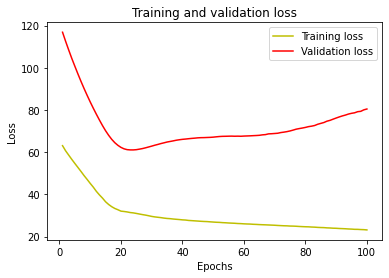


Predicted values are: 
 [[2.8759542]]

Real values are: 
 21133    12.998
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 102.4558 - mean_absolute_error: 10.1220

Mean squared error from neural net: 
 102.45580291748047

Mean absolute error from neural net: 
 10.122045516967773

Predicted values are:
  [[0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
  0.01333333 0.01333333 0.01333333 0

In [778]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from linear regression:  42.89464035915136

Mean absolute error from linear regression:  6.549399999935212

Mean squared error using decision tree:  2.402500000000002

Mean absolute error using decision tree:  1.5500000000000007

# Space CA-149

# 1 month of training data to predict the demand of 1 space for 1 day

In [779]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 10]

In [780]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 11]
test = test.loc[test['connectionTime_day'] == 1]

In [781]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [782]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_225"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_566 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_567 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_568 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 1s 679ms/step - loss: 87.5410 - mean_absolute_error: 8.4722 - val_loss: 136.1556 - val_mean_absolute_error: 11.6515
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 86.3611 - mean_absolute_error: 8.4070 - val_loss: 133.8006 - val_mean_absolute_error: 11.5500
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 25.8690 - mean_absolute_error: 4.4524 - val_loss: 19.4718 - val_mean_absolute_error: 4.3441
Epoch 47/100
1/1 [==============================] - 0s 20ms/step - loss: 24.2128 - mean_absolute_error: 4.2796 - val_loss: 17.1372 - val_mean_absolute_error: 4.0664
Epoch 48/100
1/1 [==============================] - 0s 18ms/step - loss: 22.6126 - mean_absolute_error: 4.1027 - val_loss: 14.9199 - val_mean_absolute_error: 3.7839
Epoch 49/100
1/1 [==============================] - 0s 18ms/step - loss: 21.0789 - mean_absolute_error: 3.9222 - val_loss: 12.8342 - val_mean_absolute_error: 3.4977
Epoch 50/100
1/1 [==============================] - 0s 17ms/step - loss: 19.6203 - mean_absolute_error: 3.7383 - val_loss: 10.8908 - val_mean_absolute_error: 3.2083
Epoch 51/100
1/1 [==============================] - 0s 18ms/step - loss: 18.2461 - mean_absolute_error: 3.5518 - val_loss: 9.0948 - val_mean_absolute_error: 2.9157
Epoch 52/10

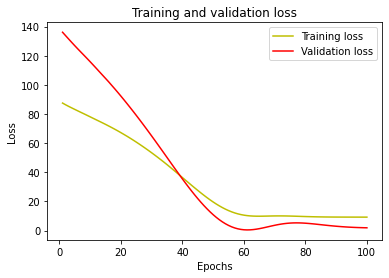


Predicted values are: 
 [[2.378858]]

Real values are: 
 13097    2.605
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 0.0511 - mean_absolute_error: 0.2261

Mean squared error from neural net: 
 0.05114017054438591

Mean absolute error from neural net: 
 0.22614192962646484

Predicted values are:
  [[0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334
  0.08333334 0.08333334 0.08333334 0.08333334 0.08333334 0.08333334]]

Real values are: 
 13097    2.605
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 162ms/step - loss: 6.3588 - mean_absolute_error: 2.5217

Mean squared error from Convolutional neural net:  6.3588032722473145

Mean absolute error from Convolutional neural net:  2.5216667652130127

Mean squared error from linear regression:  45.43434025003818

Mean absolute error from linear regression:  6.740500000002832

Mean squared error using decision tree:  12.453841000000002

Mean absolute

In [783]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 0.05114017054438591

Mean absolute error from neural net: 
 0.22614192962646484

 Mean squared error using Random Forest:  6.310344961599997

Mean absolute error Using Random Forest:  2.5120399999999994

# 1 Month to predict 1 week

In [784]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_month'] == 6]
train = train.loc[train['connectionTime_year'] == 2018]

In [785]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [786]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [787]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_571 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_572 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_573 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 374ms/step - loss: 22.5305 - mean_absolute_error: 4.1432 - val_loss: 92.4494 - val_mean_absolute_error: 9.6151
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 21.7608 - mean_absolute_error: 4.0606 - val_loss: 90.3530 - val_mean_absolute_error: 9.5054
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 17ms/step - loss: 0.1397 - mean_absolute_error: 0.2891 - val_loss: 11.6412 - val_mean_absolute_error: 3.4119
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1315 - mean_absolute_error: 0.2788 - val_loss: 11.7334 - val_mean_absolute_error: 3.4254
Epoch 98/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1236 - mean_absolute_error: 0.2687 - val_loss: 11.8306 - val_mean_absolute_error: 3.4396
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1160 - mean_absolute_error: 0.2586 - val_loss: 11.9288 - val_mean_absolute_error: 3.4538
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 0.1087 - mean_absolute_error: 0.2488 - val_loss: 12.0241 - val_mean_absolute_error: 3.4676


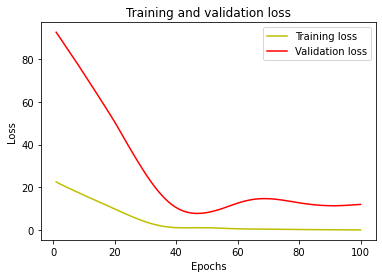


Predicted values are: 
 [[1.9836695]
 [1.6547849]
 [3.432538 ]
 [3.4622679]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 341.9560 - mean_absolute_error: 11.0766

Mean squared error from neural net: 
 341.9559631347656

Mean absolute error from neural net: 
 11.07658863067627

Predicted values are:
  [[0.24027364 0.26203716 0.21772088 0.27996832]
 [0.24382728 0.25981638 0.22354722 0.2728091 ]
 [0.24758478 0.24854559 0.21154036 0.29232928]
 [0.24740566 0.24855721 0.2112149  0.29282218]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 156ms/step - loss: 366.9423 - mean_absolute_error: 10.6735

Mean squared error from Convolutional neural net:  366.94232177734375

Mean absolute error from Convolutional neural net:  10.673501014709473

Mean squared error

In [788]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 341.9559631347656

Mean absolute error from neural net: 
 11.07658863067627

 
Mean squared error using Random Forest:  332.3196518386749

Mean absolute error Using Random Forest:  12.410937499999996


# 6 Month training 1 week predicition

In [789]:
train = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([1,2,3,4,5,6])]

In [790]:
test = DataFrameDict['CA-149'].loc[DataFrameDict['CA-149']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 7]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [791]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [792]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_576 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_577 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_578 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 361ms/step - loss: 27.3589 - mean_absolute_error: 4.5583 - val_loss: 98.8638 - val_mean_absolute_error: 9.9430
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 26.4801 - mean_absolute_error: 4.4710 - val_loss: 97.2918 - val_mean_absolute_error: 9.8637
Epoch 3/100
1/1 [==============================] - 

1/1 [==============================] - 0s 17ms/step - loss: 0.2847 - mean_absolute_error: 0.4392 - val_loss: 14.6165 - val_mean_absolute_error: 3.8231
Epoch 97/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2721 - mean_absolute_error: 0.4247 - val_loss: 14.4545 - val_mean_absolute_error: 3.8019
Epoch 98/100
1/1 [==============================] - 0s 18ms/step - loss: 0.2597 - mean_absolute_error: 0.4102 - val_loss: 14.3028 - val_mean_absolute_error: 3.7819
Epoch 99/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2478 - mean_absolute_error: 0.3958 - val_loss: 14.1627 - val_mean_absolute_error: 3.7633
Epoch 100/100
1/1 [==============================] - 0s 17ms/step - loss: 0.2365 - mean_absolute_error: 0.3858 - val_loss: 14.0355 - val_mean_absolute_error: 3.7464


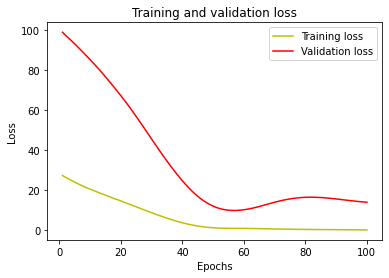


Predicted values are: 
 [[2.3826861]
 [2.0847864]
 [3.1159256]
 [3.1335633]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 332.8988 - mean_absolute_error: 10.7080

Mean squared error from neural net: 
 332.8988342285156

Mean absolute error from neural net: 
 10.70800495147705

Predicted values are:
  [[0.23411311 0.24866074 0.26324284 0.2539833 ]
 [0.23805481 0.24762246 0.2605106  0.25381216]
 [0.24695942 0.262682   0.22847825 0.26188034]
 [0.24700907 0.26271784 0.22828047 0.2619926 ]]

Real values are: 
 4140     3.999
4149    38.373
4253     0.588
4254     0.734
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 163ms/step - loss: 366.9418 - mean_absolute_error: 10.6735

Mean squared error from Convolutional neural net:  366.9418029785156

Mean absolute error from Convolutional neural net:  10.673501014709473

Mean squared error 

In [793]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 332.8988342285156

Mean absolute error from neural net: 
 10.70800495147705

Mean squared error using decision tree:  284.55755099999993

Mean absolute error using decision tree:  13.3385

# Space CA-511

# 1 month of training data to predict the demand of 1 space for 1 day

In [795]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [796]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'] == 1]

In [797]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [798]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_581 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_582 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_583 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 354ms/step - loss: 73.7967 - mean_absolute_error: 7.2136 - val_loss: 268.5486 - val_mean_absolute_error: 13.0692
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 72.5447 - mean_absolute_error: 7.1258 - val_loss: 265.1460 - val_mean_absolute_error: 12.9419
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 18ms/step - loss: 24.6814 - mean_absolute_error: 4.4081 - val_loss: 110.8255 - val_mean_absolute_error: 7.2951
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 24.2718 - mean_absolute_error: 4.3680 - val_loss: 108.0413 - val_mean_absolute_error: 7.2301
Epoch 48/100
1/1 [==============================] - 0s 17ms/step - loss: 23.9276 - mean_absolute_error: 4.3284 - val_loss: 105.4347 - val_mean_absolute_error: 7.1653
Epoch 49/100
1/1 [==============================] - 0s 17ms/step - loss: 23.6444 - mean_absolute_error: 4.2898 - val_loss: 103.0117 - val_mean_absolute_error: 7.1010
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 23.4111 - mean_absolute_error: 4.2517 - val_loss: 100.7846 - val_mean_absolute_error: 7.0535
Epoch 51/100
1/1 [==============================] - 0s 37ms/step - loss: 23.2211 - mean_absolute_error: 4.2147 - val_loss: 98.7547 - val_mean_absolute_error: 7.1122
Epoch

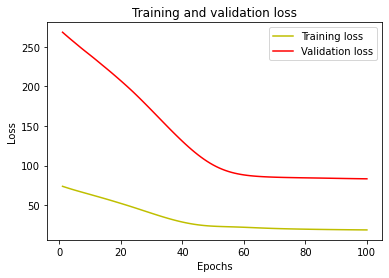


Predicted values are: 
 [[5.02442 ]
 [2.206888]
 [8.607376]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 22.2743 - mean_absolute_error: 4.4680

Mean squared error from neural net: 
 22.274343490600586

Mean absolute error from neural net: 
 4.468023300170898

Predicted values are:
  [[0.05093607 0.04706136 0.03901721 0.04632048 0.04877415 0.04212227
  0.04186954 0.04794127 0.04157554 0.04522637 0.04595656 0.0404169
  0.04446112 0.039936   0.03946237 0.04167229 0.04484721 0.0404564
  0.04008781 0.04227362 0.04523408 0.04065877 0.04369267]
 [0.04503579 0.0449858  0.04216547 0.04456661 0.04478468 0.04279831
  0.04327652 0.04550098 0.04338864 0.04349802 0.0443895  0.04312536
  0.04272234 0.04197646 0.04258457 0.04306139 0.04364241 0.04274852
  0.04252213 0.04326779 0.0443963  0.04246612 0.04309629]
 [0.04877708 0.04975151 0.04356568 0.03795979 0.04390561 0.04050644
  0.04

In [799]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 22.274343490600586

Mean absolute error from neural net: 
 4.468023300170898

 Mean squared error using decision tree:  27.891446999999996

Mean absolute error using decision tree:  4.433666666666666

# 1 Month to predict 1 week

In [801]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
train = train.loc[train['connectionTime_month'] == 9]

In [802]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [803]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [804]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_586 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_587 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_588 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 360ms/step - loss: 73.6723 - mean_absolute_error: 7.1929 - val_loss: 264.0593 - val_mean_absolute_error: 12.8982
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 72.2805 - mean_absolute_error: 7.0996 - val_loss: 261.5416 - val_mean_absolute_error: 12.8054
Epoch 3/100
1/1 [==============================

Epoch 46/100
1/1 [==============================] - 0s 17ms/step - loss: 25.9298 - mean_absolute_error: 4.4012 - val_loss: 129.9123 - val_mean_absolute_error: 8.0436
Epoch 47/100
1/1 [==============================] - 0s 17ms/step - loss: 25.6045 - mean_absolute_error: 4.3683 - val_loss: 126.6642 - val_mean_absolute_error: 7.8946
Epoch 48/100
1/1 [==============================] - 0s 20ms/step - loss: 25.2892 - mean_absolute_error: 4.3363 - val_loss: 123.4967 - val_mean_absolute_error: 7.7441
Epoch 49/100
1/1 [==============================] - 0s 19ms/step - loss: 24.9785 - mean_absolute_error: 4.3054 - val_loss: 120.4420 - val_mean_absolute_error: 7.5927
Epoch 50/100
1/1 [==============================] - 0s 18ms/step - loss: 24.6675 - mean_absolute_error: 4.2757 - val_loss: 117.4904 - val_mean_absolute_error: 7.4402
Epoch 51/100
1/1 [==============================] - 0s 19ms/step - loss: 24.3507 - mean_absolute_error: 4.2470 - val_loss: 114.6610 - val_mean_absolute_error: 7.3503
Epoc

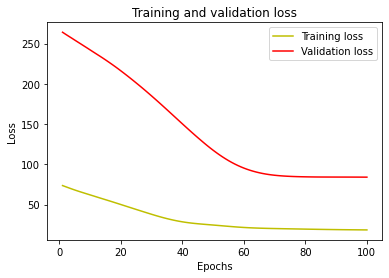


Predicted values are: 
 [[ 6.3288107]
 [ 6.1911755]
 [ 5.979045 ]
 [ 4.847539 ]
 [11.01987  ]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
10926     8.300
11022    13.893
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 14ms/step - loss: 16.7098 - mean_absolute_error: 3.2797

Mean squared error from neural net: 
 16.70981216430664

Mean absolute error from neural net: 
 3.279749631881714

Predicted values are:
  [[0.0462026  0.04191185 0.04897314 0.04209273 0.04963428 0.04523448
  0.04374187 0.04538179 0.04607852 0.04000811 0.04746816 0.03532575
  0.04430994 0.0456216  0.03947382 0.04352805 0.04158463 0.04501686
  0.03793681 0.03709578 0.04881566 0.0415953  0.04296832]
 [0.04608549 0.04197412 0.0487692  0.04219118 0.04937189 0.04518375
  0.0437207  0.04527956 0.04598154 0.0401496  0.04733016 0.0356334
  0.04428355 0.04554358 0.03960267 0.04358309 0.04157728 0.04493456
  0.03811605 0.03735989 0.04863935 0.04160425 0.04308507]
 [0.0459

In [805]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 16.70981216430664

Mean absolute error from neural net: 
 3.279749631881714

 
Mean squared error from linear regression:  33.69077866010826

Mean absolute error from linear regression:  4.493740802610845

# 6 Month training 1 week predicition

In [806]:
train = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]

train = train.loc[train['connectionTime_month'].isin([4,5,6,7,8,9])]

In [807]:
test = DataFrameDict['CA-511'].loc[DataFrameDict['CA-511']['connectionTime_year'] == 2018]
test = test.loc[test['connectionTime_month'] == 10]
test = test.loc[test['connectionTime_day'].isin([1,2,3,4,5,6,7])]

In [808]:
y_train = train['kWhDelivered']
x_train = train.drop('kWhDelivered', axis=1)
x_train = singleNumeric(x_train)
y_train = singleNumeric(y_train)
x_trainScaled = scaleData(x_train)

In [809]:
y_test = test['kWhDelivered']
x_test = test.drop('kWhDelivered', axis=1)
x_test = singleNumeric(x_test)
y_test = singleNumeric(y_test)
x_testScaled = scaleData(x_test)

Model: "sequential_235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_591 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_592 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_593 (Dense)            (None, 1)                 65        
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 108ms/step - loss: 91.4445 - mean_absolute_error: 8.0675 - val_loss: 146.5369 - val_mean_absolute_error: 9.4153
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 86.7743 - mean_absolute_error: 7.7797 - val_loss: 140.6463 - val_mean_absolute_error: 9.1009
Epoch 3/100
2/2 [==============================] 

Epoch 96/100
2/2 [==============================] - 0s 18ms/step - loss: 23.0600 - mean_absolute_error: 4.1874 - val_loss: 69.8722 - val_mean_absolute_error: 6.1158
Epoch 97/100
2/2 [==============================] - 0s 19ms/step - loss: 23.0393 - mean_absolute_error: 4.1877 - val_loss: 70.0295 - val_mean_absolute_error: 6.1312
Epoch 98/100
2/2 [==============================] - 0s 43ms/step - loss: 23.0094 - mean_absolute_error: 4.1845 - val_loss: 70.1956 - val_mean_absolute_error: 6.1472
Epoch 99/100
2/2 [==============================] - 0s 46ms/step - loss: 23.0079 - mean_absolute_error: 4.1792 - val_loss: 70.4058 - val_mean_absolute_error: 6.1652
Epoch 100/100
2/2 [==============================] - 0s 22ms/step - loss: 22.9788 - mean_absolute_error: 4.1716 - val_loss: 70.4419 - val_mean_absolute_error: 6.1689


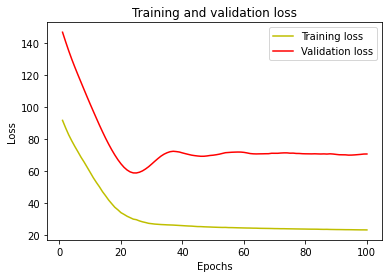


Predicted values are: 
 [[5.7461243]
 [5.675754 ]
 [5.572845 ]
 [4.655725 ]
 [9.024312 ]]

Real values are: 
 10737    11.133
10743     7.058
10753     6.163
10926     8.300
11022    13.893
Name: kWhDelivered, dtype: float64
1/1 [==============================] - 0s 13ms/step - loss: 13.7384 - mean_absolute_error: 3.2727

Mean squared error from neural net: 
 13.738385200500488

Mean absolute error from neural net: 
 3.272716522216797

Predicted values are:
  [[0.01663877 0.01546041 0.01437892 0.01487516 0.01518337 0.01642039
  0.016229   0.01625676 0.0146436  0.01420491 0.01634958 0.01696879
  0.01476201 0.01782445 0.01384546 0.01386102 0.01585121 0.01544916
  0.01575327 0.01455192 0.01491026 0.01374593 0.01551032 0.01491816
  0.01704553 0.01579896 0.01411806 0.01560397 0.01642053 0.01576176
  0.01514937 0.01543389 0.01609386 0.01552014 0.01434937 0.01409995
  0.01519749 0.01453476 0.01435302 0.01571871 0.01641527 0.01519078
  0.0134461  0.01435815 0.01637317 0.01625978 0.01571562 0.

In [810]:
models(x_train, y_train, x_trainScaled, x_test, y_test, x_testScaled)

Mean squared error from neural net: 
 13.738385200500488

Mean absolute error from neural net: 
 3.272716522216797

 
Mean squared error using Random Forest:  42.1449649392832

Mean absolute error Using Random Forest:  4.5062983333333255

# Overall for Individual Spaces

When ran on the 33 different DataFrames the following models occured:

Sequential Neural Network: 20 Times

Convolutional Neural Network: 6 Times

Linear Regression: 9 Times

Decision Tree: 13 Times

Random Forest: 18 Times

# General

Some scores are extremely low such as:

Space 506

1 Month 1 Day

Mean squared error using decision tree:  0.3528360000000014

Mean absolute error using decision tree:  0.5940000000000012

Mean squared error using Random Forest:  0.4361281600000201

Mean absolute error Using Random Forest:  0.6604000000000152

I think this is a sign of underfitting and there not being enough data for some spaces to accurately create a model. However some scores are more reasonable and still more accurate than for all the spaces, I believe in some cases indivual space predicitions are possible and can have value due to their improved accuracy.

# Overall

The sequential Neural Network was most often the most effective at creating predicitons.

The models were more effective when data was reduced to predict on a single spaces demand